In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

In [2]:
def filter_df(df, filters):
    mask = pd.Series(True, index=df.index)
    for col, vals in filters.items():
        mask &= df[col].isin(vals)
    return df[mask]

In [3]:
def plot_scores_and_boxplots(df_estimators_sim, df_gamma_selection, 
                             estimator='ipr', pi_target=0.25, kernel='rbf',
                             y_lim_list=[[None, None],[None, None],[None, None],[None, None]]):
    eps = 0.1

    df_estimators_sim.loc[:,'MSE'] = (df_estimators_sim['pi'] - df_estimators_sim['pi_target'])**2

    df_gamma_selection = df_gamma_selection[df_gamma_selection['gamma_selection_name'].isin(['one_over_p', 'grid', 'bootstrap_var', 'bootstrap_mse'])]
    
    p_seq = [5,5,20,5]
    dist_seq = ['Gauss','Gauss','Gauss','Cauchy']
    filter_column_0 = {
        'sim_scenario': ['sim_par_4'],
        'n_plus': [150],
        'pi_target': [pi_target],
        'estimator': [estimator],
        'kernel': [kernel],
    }

    filter_column_1 = {
        'sim_scenario': ['sim_par_4'],
        'n_plus': [150],
        'pi_target': [1-pi_target],
        'estimator': [estimator],
        'kernel': [kernel]
    }

    filter_column_2 = {
        'sim_scenario': ['sim_par_4-p-20'],
        'n_plus': [150],
        'pi_target': [pi_target],
        'estimator': [estimator],
        'kernel': [kernel]
    }

    filter_column_3 = {
        'sim_scenario': ['sim_par_4-Cauchy'],
        'n_plus': [150],
        'pi_target': [pi_target],
        'estimator': [estimator],
        'kernel': [kernel]
    }

    filter_columns = [filter_column_0, filter_column_1, filter_column_2, filter_column_3] 
    
    fig, axes = plt.subplots(2, 4, sharex=False, figsize=(30, 10), height_ratios=[2, 2])
    fig.suptitle("Estimator: "+estimator+", kernel: "+kernel+" (n_plus=n_minus="+str(150)+", n_target="+str(300)+")", fontsize=20, fontweight='bold')
    cmap = plt.get_cmap('tab20')

    for i in range(4):
        df_estimators_sim_tmp = filter_df(df_estimators_sim, filter_columns[i]).copy()
        df_gamma_selection_tmp = filter_df(df_gamma_selection, filter_columns[i]).copy()
        gamma_seq = np.sort(df_estimators_sim_tmp['gamma'].unique().tolist())
        
        df_tmp_1 = df_estimators_sim_tmp[['gamma', 'type', 'MSE']].groupby(['gamma', 'type']).aggregate('mean').reset_index()
        df_tmp_2 = df_estimators_sim_tmp[['gamma', 'type', 'pi']].groupby(['gamma', 'type']).aggregate(var_emp=('pi', 'var')).reset_index()
        df_tmp_3 = df_estimators_sim_tmp[['gamma', 'type', 'var_n']].groupby(['gamma', 'type']).aggregate(
            var_as_mean=('var_n', 'mean'),
            var_as_ql=('var_n', lambda x: x.quantile(0.05)),
            var_as_qu=('var_n', lambda x: x.quantile(0.95))
        ).reset_index()
        if kernel == 'rbf':
            df_tmp_4 = df_estimators_sim_tmp[['gamma', 'type', 'var_rbf']].groupby(['gamma', 'type']).aggregate(var_as_rbf=('var_rbf', 'mean')).reset_index()
            dfs_tmp = [df_tmp_1, df_tmp_2, df_tmp_3, df_tmp_4]
        else:
            dfs_tmp = [df_tmp_1, df_tmp_2, df_tmp_3]
        join_cols = ['gamma', 'type']
        df_first_plot = reduce(lambda left, right: pd.merge(left, right, on=join_cols, how='inner'), dfs_tmp)


        df_gamma_selection_tmp.loc[:,'gamma_selection_U_V'] = df_gamma_selection_tmp['gamma_selection_name'] + '_' + df_gamma_selection_tmp['type']
        gamma_selection_methods_dict = {
            'bootstrap_var_U' : 'Bootstrap-VAR (U)',
            'bootstrap_var_V' : 'Bootstrap-VAR (V)',
            'bootstrap_mse_U' : 'Bootstrap-MSE (U)',
            'bootstrap_mse_V' : 'Bootstrap-MSE (V)',
            'grid_U' : 'Grid-EST.VAR (U)',
            'grid_V' : 'Grid-EST.VAR (V)',
            'one_over_p_U' : '1/p'
        }
        df_second_plot = df_gamma_selection_tmp
        df_second_plot['gamma_selection_U_V'] = df_second_plot['gamma_selection_U_V'].map(gamma_selection_methods_dict)
        hue_order = [gamma_selection_methods_dict[key] for key in gamma_selection_methods_dict.keys()]

        df_first_plot_U = df_first_plot[df_first_plot['type'] == 'U']
        df_first_plot_V = df_first_plot[df_first_plot['type'] == 'V']
        axes[0, i].plot(df_first_plot_U['gamma'], df_first_plot_U['var_emp'], label='Empirical var. (U)', color=cmap(0))
        axes[0, i].plot(df_first_plot_V['gamma'], df_first_plot_V['var_emp'], label='Empirical var. (V)', color=cmap(0), linestyle='dashed')
        axes[0, i].plot(df_first_plot_U['gamma'], df_first_plot_U['MSE'], label='MSE (U)', color=cmap(2))
        axes[0, i].plot(df_first_plot_V['gamma'], df_first_plot_V['MSE'], label='MSE (V)', color=cmap(2), linestyle='dashed')
        axes[0, i].fill_between(df_first_plot_U['gamma'], df_first_plot_U['var_as_ql'], df_first_plot_U['var_as_qu'], label='Est. asymptotic var. 90% (U)', 
                                color=cmap(4), alpha=0.05)
        axes[0, i].fill_between(df_first_plot_V['gamma'], df_first_plot_V['var_as_ql'], df_first_plot_V['var_as_qu'], label='Est. asymptotic var. 90% (V)', 
                                color=cmap(4), alpha=0.1, hatch='//', facecolor='none')
        axes[0, i].plot(df_first_plot_U['gamma'], df_first_plot_U['var_as_mean'], label='Est. asymptotic var. (U)', color=cmap(4))
        axes[0, i].plot(df_first_plot_V['gamma'], df_first_plot_V['var_as_mean'], label='Est. asymptotic var. (V)', color=cmap(4), linestyle='dashed')
        if (i < 3) and (kernel == 'rbf'):
            axes[0, i ].plot(df_first_plot_U['gamma'], df_first_plot_U['var_as_rbf'], label='As. var RBF-Gaussian', color='gray', linestyle='dotted')
        axes[0, i].legend()
        axes[0, i].set_ylabel("")
        
        axes[0, i].set_title('pi_target = '+str(filter_columns[i]['pi_target'][0])+", p = "+str(p_seq[i])+", distribution: "+dist_seq[i])
        axes[0, i].set_xlim(np.min(df_second_plot['gamma_optimal'])*(1-eps), np.max(df_second_plot['gamma_optimal'])*(1+eps))
        

        sns.boxplot(df_second_plot, x='gamma_optimal', y='gamma_selection_U_V',
                    hue='gamma_selection_U_V', hue_order=hue_order, order=hue_order,
                    palette='tab20', ax=axes[1, i], legend=False)
        axes[1, i].set_xlim(np.min(df_second_plot['gamma_optimal'])*(1-eps), np.max(df_second_plot['gamma_optimal'])*(1+eps))
        axes[1, i].set_ylabel("")
        axes[1, i].set_xlabel("Gamma")

        if i > 0:
            axes[1, i].set_yticks([])
            axes[1, i].set_ylabel('')
            axes[0, i].set_ylabel('')
        # if i == 2:
        #     measurements_tmp = np.array(df_first_plot.loc[(df_first_plot['gamma'] < np.max(df_second_plot['gamma_optimal'])) & (df_first_plot['gamma'] > np.min(df_second_plot['gamma_optimal'])),
        #                                                   ['MSE', 'var_as_ql', 'var_as_qu', 'var_emp']])
        #     axes[0, i].set_ylim(np.min(measurements_tmp), np.max(measurements_tmp))
        # if i == 3:
        #     measurements_tmp = np.array(df_first_plot.loc[(df_first_plot['gamma'] < np.max(df_second_plot['gamma_optimal'])) & (df_first_plot['gamma'] > np.min(df_second_plot['gamma_optimal'])),
        #                                                   ['MSE', 'var_as_ql', 'var_as_qu', 'var_emp']])
        #     axes[0, i].set_ylim(np.min(measurements_tmp), np.quantile(measurements_tmp, 0.6))
        axes[0, i].set_ylim(y_lim_list[i][0], y_lim_list[i][1])
            

    plt.tight_layout()
    plt.show()
        

In [16]:
def plot_scores_and_boxplots2(df_estimators_sim, df_gamma_selection, 
                             estimator='ipr', pi_target=0.25, kernel='rbf',
                             y_lim_list=[[None, None],[None, None],[None, None]]):
    eps = 0.1

    df_estimators_sim.loc[:,'MSE'] = (df_estimators_sim['pi'] - df_estimators_sim['pi_target'])**2

    df_gamma_selection = df_gamma_selection[df_gamma_selection['gamma_selection_name'].isin(['one_over_p', 'grid', 'bootstrap_var', 'bootstrap_mse'])]
    
    p_seq = [5,5,5]
    dist_seq = ['Gauss','Gauss','Gauss']
    filter_column_0 = {
        'sim_scenario': ['sim_par_4'],
        'n_plus': [50],
        'pi_target': [pi_target],
        'estimator': [estimator],
        'kernel': [kernel],
    }

    filter_column_1 = {
        'sim_scenario': ['sim_par_4'],
        'n_plus': [150],
        'pi_target': [pi_target],
        'estimator': [estimator],
        'kernel': [kernel],
    }

    filter_column_2 = {
        'sim_scenario': ['sim_par_4'],
        'n_plus': [250],
        'pi_target': [pi_target],
        'estimator': [estimator],
        'kernel': [kernel],
    }

    filter_columns = [filter_column_0, filter_column_1, filter_column_2] 
    
    fig, axes = plt.subplots(2, 3, sharex=False, figsize=(30, 8), height_ratios=[2, 2])
    fig.suptitle("Estimator: "+estimator+", kernel: "+kernel+'(pi_target = '+str(filter_columns[0]['pi_target'][0])+", p = "+str(p_seq[0])+", distribution: "+dist_seq[0]+")", fontsize=20, fontweight='bold')
    cmap = plt.get_cmap('tab20')

    for i in range(3):
        df_estimators_sim_tmp = filter_df(df_estimators_sim, filter_columns[i]).copy()
        df_gamma_selection_tmp = filter_df(df_gamma_selection, filter_columns[i]).copy()
        gamma_seq = np.sort(df_estimators_sim_tmp['gamma'].unique().tolist())
        
        df_tmp_1 = df_estimators_sim_tmp[['gamma', 'type', 'MSE']].groupby(['gamma', 'type']).aggregate('mean').reset_index()
        df_tmp_2 = df_estimators_sim_tmp[['gamma', 'type', 'pi']].groupby(['gamma', 'type']).aggregate(var_emp=('pi', 'var')).reset_index()
        df_tmp_3 = df_estimators_sim_tmp[['gamma', 'type', 'var_n']].groupby(['gamma', 'type']).aggregate(
            var_as_mean=('var_n', 'mean'),
            var_as_ql=('var_n', lambda x: x.quantile(0.05)),
            var_as_qu=('var_n', lambda x: x.quantile(0.95))
        ).reset_index()
        if kernel == 'rbf':
            df_tmp_4 = df_estimators_sim_tmp[['gamma', 'type', 'var_rbf']].groupby(['gamma', 'type']).aggregate(var_as_rbf=('var_rbf', 'mean')).reset_index()
            dfs_tmp = [df_tmp_1, df_tmp_2, df_tmp_3, df_tmp_4]
        else:
            dfs_tmp = [df_tmp_1, df_tmp_2, df_tmp_3]
        join_cols = ['gamma', 'type']
        df_first_plot = reduce(lambda left, right: pd.merge(left, right, on=join_cols, how='inner'), dfs_tmp)


        df_gamma_selection_tmp.loc[:,'gamma_selection_U_V'] = df_gamma_selection_tmp['gamma_selection_name'] + '_' + df_gamma_selection_tmp['type']
        gamma_selection_methods_dict = {
            'bootstrap_var_U' : 'Bootstrap-VAR (U)',
            'bootstrap_var_V' : 'Bootstrap-VAR (V)',
            'bootstrap_mse_U' : 'Bootstrap-MSE (U)',
            'bootstrap_mse_V' : 'Bootstrap-MSE (V)',
            'grid_U' : 'Grid-EST.VAR (U)',
            'grid_V' : 'Grid-EST.VAR (V)',
            'one_over_p_U' : '1/p'
        }
        df_second_plot = df_gamma_selection_tmp
        df_second_plot['gamma_selection_U_V'] = df_second_plot['gamma_selection_U_V'].map(gamma_selection_methods_dict)
        hue_order = [gamma_selection_methods_dict[key] for key in gamma_selection_methods_dict.keys()]

        df_first_plot_U = df_first_plot[df_first_plot['type'] == 'U']
        df_first_plot_V = df_first_plot[df_first_plot['type'] == 'V']
        axes[0, i].plot(df_first_plot_U['gamma'], df_first_plot_U['var_emp'], label='Empirical var. (U)', color=cmap(0))
        axes[0, i].plot(df_first_plot_V['gamma'], df_first_plot_V['var_emp'], label='Empirical var. (V)', color=cmap(0), linestyle='dashed')
        axes[0, i].plot(df_first_plot_U['gamma'], df_first_plot_U['MSE'], label='MSE (U)', color=cmap(2))
        axes[0, i].plot(df_first_plot_V['gamma'], df_first_plot_V['MSE'], label='MSE (V)', color=cmap(2), linestyle='dashed')
        axes[0, i].fill_between(df_first_plot_U['gamma'], df_first_plot_U['var_as_ql'], df_first_plot_U['var_as_qu'], label='Est. asymptotic var. 90% (U)', 
                                color=cmap(4), alpha=0.05)
        axes[0, i].fill_between(df_first_plot_V['gamma'], df_first_plot_V['var_as_ql'], df_first_plot_V['var_as_qu'], label='Est. asymptotic var. 90% (V)', 
                                color=cmap(4), alpha=0.1, hatch='//', facecolor='none')
        axes[0, i].plot(df_first_plot_U['gamma'], df_first_plot_U['var_as_mean'], label='Est. asymptotic var. (U)', color=cmap(4))
        axes[0, i].plot(df_first_plot_V['gamma'], df_first_plot_V['var_as_mean'], label='Est. asymptotic var. (V)', color=cmap(4), linestyle='dashed')
        if (i < 3) and (kernel == 'rbf'):
            axes[0, i ].plot(df_first_plot_U['gamma'], df_first_plot_U['var_as_rbf'], label='As. var RBF-Gaussian', color='gray', linestyle='dotted')
        axes[0, i].legend()
        axes[0, i].set_ylabel("")
        
        axes[0, i].set_title("n_plus=n_minus="+str(filter_columns[i]['n_plus'])+", n_target="+str(2*filter_columns[i]['n_plus']))
        axes[0, i].set_xlim(np.min(df_second_plot['gamma_optimal'])*(1-eps), np.max(df_second_plot['gamma_optimal'])*(1+eps))
        

        sns.boxplot(df_second_plot, x='gamma_optimal', y='gamma_selection_U_V',
                    hue='gamma_selection_U_V', hue_order=hue_order, order=hue_order,
                    palette='tab20', ax=axes[1, i], legend=False)
        axes[1, i].set_xlim(np.min(df_second_plot['gamma_optimal'])*(1-eps), np.max(df_second_plot['gamma_optimal'])*(1+eps))
        axes[1, i].set_ylabel("")
        axes[1, i].set_xlabel("Gamma")

        if i > 0:
            axes[1, i].set_yticks([])
            axes[1, i].set_ylabel('')
            axes[0, i].set_ylabel('')
        axes[0, i].set_ylim(y_lim_list[i][0], y_lim_list[i][1])
            

    plt.tight_layout()
    plt.show()
        

In [136]:
df = pd.concat([
    pd.read_csv('results/results_standard_mse_new.csv', index_col=0),
    pd.read_csv('results/results_dimension_mse_new.csv', index_col=0),
    pd.read_csv('results/results_heavy_tail_mse_new.csv', index_col=0)
])
sim_params_colnames = ['sim_scenario', 'n_plus', 'n_minus', 'n_target', 'pi_target', 
                       'gamma_selection_name', 'estimator', 'type', 'kernel',
                        'x', 'x_name', 'p', 'distributions', 'method_name']
values_colnames = ['pi', 'var_n', 'var', 'gamma', 'MSE', 'time', 'count_sim']
df = df.drop_duplicates(sim_params_colnames, keep='last')

In [156]:
df_all = pd.concat([
    pd.read_csv('results/results_standard_all_new.csv', index_col=0),
    pd.read_csv('results/results_dimension_all_new.csv', index_col=0),
    pd.read_csv('results/results_heavy_tail_all_new.csv', index_col=0)
])
sim_params_colnames = ['sim_scenario', 'n_plus', 'n_minus', 'n_target', 'pi_target', 
                       'gamma_selection_name', 'estimator', 'type', 'kernel',
                        'x', 'x_name', 'p', 'distributions', 'method_name']
values_colnames = ['pi', 'var_n', 'var', 'gamma', 'MSE', 'time', 'count_sim']
df_all = df_all.drop_duplicates(sim_params_colnames+['seed'], keep='last')
df_all['CI_L'] = df_all['pi'] - 1.96*np.sqrt(df_all['var_n'])
df_all['CI_U'] = df_all['pi'] + 1.96*np.sqrt(df_all['var_n'])
df_all = df_all[~df_all['seed'].isna()]

In [5]:
def plot_barplots_mse(df, pi_target=0.25, kernel=['rbf'], estimator=['ipr']):
    scenarios_list = ['sim_par_1', 'sim_par_4', 'sim_par_7']
    p_seq = [5,5,20,5]
    dist_seq = ['Gaussian','Gaussian','Gaussian','Cauchy']
    pi_target_seq = [pi_target, 1 - pi_target, pi_target, pi_target]

    fig, axes = plt.subplots(3, 4, sharex=False, figsize=(20, 10))
    # fig.suptitle("Kernel: "+kernel+" (n_plus=n_minus="+str(150)+", n_target="+str(300)+")", fontsize=20, fontweight='bold')
    cmap = plt.get_cmap('tab20')

    for i in range(4):
        for j in range(3):
            df_tmp = filter_df(df, {'sim_scenario': [scenarios_list[j]],
                                    'p': [p_seq[i]],
                                    'distributions': [dist_seq[i]],
                                    'pi_target': [pi_target_seq[i]],
                                    'kernel':kernel,
                                    'estimator': estimator}).copy()
            gamma_selection_methods_dict = {
                'ipr_bootstrap_var_U' : 'IPR Bootstrap-VAR (U)',
                'ipr_bootstrap_var_V' : 'IPR Bootstrap-VAR (V)',
                'ipr_bootstrap_mse_U' : 'IPR Bootstrap-MSE (U)',
                'ipr_bootstrap_mse_V' : 'IPR Bootstrap-MSE (V)',
                'ipr_grid_U' : 'IPR Grid-EST.VAR (U)',
                'ipr_grid_V' : 'IPR Grid-EST.VAR (V)',
                'ipr_one_over_p_U' : 'IPR 1/p (U)',
                'ipr_one_over_p_V' : 'IPR 1/p (V)',
                'nrm_bootstrap_var_U' : 'NRM Bootstrap-VAR (U)',
                'nrm_bootstrap_var_V' : 'NRM Bootstrap-VAR (V)',
                'nrm_bootstrap_mse_U' : 'NRM Bootstrap-MSE (U)',
                'nrm_bootstrap_mse_V' : 'NRM Bootstrap-MSE (V)',
                'nrm_grid_U' : 'NRM Grid-EST.VAR (U)',
                'nrm_grid_V' : 'NRM Grid-EST.VAR (V)',
                'nrm_one_over_p_U' : 'NRM 1/p',
                'nrm_one_over_p_V' : 'NRM 1/p (V)'
            }
            df_tmp.loc[:,'estimator_gamma_selection_U_V'] = df_tmp['estimator'] +"_"+df_tmp['gamma_selection_name'] + '_' + df_tmp['type']
            df_tmp['estimator_gamma_selection_U_V'] = df_tmp['estimator_gamma_selection_U_V'].map(gamma_selection_methods_dict)
            hue_order = [gamma_selection_methods_dict[key] for key in gamma_selection_methods_dict.keys() if gamma_selection_methods_dict[key] in df_tmp['estimator_gamma_selection_U_V'].unique() ]
            sns.barplot(df_tmp, x='x', y='MSE', ax=axes[j,i], hue='estimator_gamma_selection_U_V', palette='tab20', errorbar=None,
                        hue_order=hue_order)
            # axes[j,i].legend().remove()
            leg = axes[j, i].get_legend()
            if leg:
                leg.remove()
            if df_tmp.shape[0] > 0:
                # print(df_tmp.shape[0])
                axes[j,i].set_xlabel(df_tmp['x_name'].iloc[0])
    fig.legend(*axes[0, 0].get_legend_handles_labels(),loc='upper center', ncol=4, fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [189]:
def plot_barplots_mse2(df, pi_target=0.25, kernel=['rbf'], estimator=['ipr']):
    scenarios_list = ['sim_par_1', 'sim_par_4', 'sim_par_7']
    p_seq = [5,5,5]
    dist_seq = ['Gaussian','Gaussian','Gaussian']
    pi_target_seq = [pi_target, pi_target, pi_target]

    fig, axes = plt.subplots(2, 3, sharex=False, figsize=(20, 5), height_ratios=[1, 0.001])
    # fig.suptitle("Kernel: "+kernel+" (n_plus=n_minus="+str(150)+", n_target="+str(300)+")", fontsize=20, fontweight='bold')
    cmap = plt.get_cmap('tab20')

    for i in range(3):
        for j in range(1):
            df_tmp = filter_df(df, {'sim_scenario': [scenarios_list[i]],
                                    'p': [p_seq[j]],
                                    'distributions': [dist_seq[j]],
                                    'pi_target': [pi_target_seq[j]],
                                    'kernel':kernel,
                                    'estimator': estimator}).copy()
            gamma_selection_methods_dict = {
                'ipr_bootstrap_var_U' : 'IPR Bootstrap-VAR (U)',
                'ipr_bootstrap_var_V' : 'IPR Bootstrap-VAR (V)',
                'ipr_bootstrap_mse_U' : 'IPR Bootstrap-MSE (U)',
                'ipr_bootstrap_mse_V' : 'IPR Bootstrap-MSE (V)',
                'ipr_grid_U' : 'IPR Grid-EST.VAR (U)',
                'ipr_grid_V' : 'IPR Grid-EST.VAR (V)',
                'ipr_one_over_p_U' : 'IPR 1/p (U)',
                'ipr_one_over_p_V' : 'IPR 1/p (V)',
                'nrm_bootstrap_var_U' : 'NRM Bootstrap-VAR (U)',
                'nrm_bootstrap_var_V' : 'NRM Bootstrap-VAR (V)',
                'nrm_bootstrap_mse_U' : 'NRM Bootstrap-MSE (U)',
                'nrm_bootstrap_mse_V' : 'NRM Bootstrap-MSE (V)',
                'nrm_grid_U' : 'NRM Grid-EST.VAR (U)',
                'nrm_grid_V' : 'NRM Grid-EST.VAR (V)',
                'nrm_one_over_p_U' : 'NRM 1/p',
                'nrm_one_over_p_V' : 'NRM 1/p (V)'
            }
            df_tmp.loc[:,'estimator_gamma_selection_U_V'] = df_tmp['estimator'] +"_"+df_tmp['gamma_selection_name'] + '_' + df_tmp['type']
            df_tmp['estimator_gamma_selection_U_V'] = df_tmp['estimator_gamma_selection_U_V'].map(gamma_selection_methods_dict)
            hue_order = [gamma_selection_methods_dict[key] for key in gamma_selection_methods_dict.keys() if gamma_selection_methods_dict[key] in df_tmp['estimator_gamma_selection_U_V'].unique() ]
            sns.barplot(df_tmp, x='x', y='MSE', ax=axes[j,i], hue='estimator_gamma_selection_U_V', palette='tab20', errorbar=None,
                        hue_order=hue_order)
            # axes[j,i].legend().remove()
            leg = axes[j, i].get_legend()
            if leg:
                leg.remove()
            if df_tmp.shape[0] > 0:
                # print(df_tmp.shape[0])
                axes[j,i].set_xlabel(df_tmp['x_name'].iloc[0])
    fig.legend(*axes[0, 0].get_legend_handles_labels(),loc='upper center', ncol=4, fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [177]:
def plot_ci_curve(ax, df, estimator, kernel, gamma_selection_name, type, pi_target, sim_scenario, n_plus, n_target,
                  p, distributions):

    N = len(estimator)
    for i in range(N):
        df_tmp = df_all[(df_all['sim_scenario'] == sim_scenario) & (df_all['n_plus'] == n_plus) & (df_all['n_target'] == n_target) & (df_all['estimator'] == estimator[i]) & (df_all['kernel'] == kernel[i]) & (df_all['pi_target'] == pi_target) & (df_all['gamma_selection_name'] == gamma_selection_name[i]) & (df_all['type'] == type[i]) & (df_all['p'] == p)  & (df_all['distributions'] == distributions)]
        x_values = np.hstack((df_tmp['CI_L'],df_tmp['CI_U']))
        step_values = np.hstack((np.ones(100),-np.ones(100)))

        step_values = step_values[np.argsort(x_values)]
        x_values = x_values[np.argsort(x_values)]
        y_values = np.cumsum(step_values)

        ax.plot(x_values, y_values/100, label= np.array(df_tmp['method_name'])[0] + " ("+str(np.round(np.sum(np.diff(x_values)*y_values[:199]/100), 2))+")")
    ax.vlines(x=pi_target, ymin=0, ymax=1, linestyle='dotted', color='gray')
    ax.hlines(y=0.95, xmin=np.min(x_values), xmax=np.max(x_values), linestyle='dotted', color='gray')
    ax.legend()

In [166]:
df_estimators_sim_list = [
    pd.read_csv('results_grid/df_estimators_sim_par_4_025.csv'),
    pd.read_csv('results_grid/df_estimators_sim_par_4_075.csv'),
    pd.read_csv('results_grid/df_estimators_sim_par_4-p-20_025.csv'),
    pd.read_csv('results_grid/df_estimators_sim_par_4-Cauchy_025.csv'),
    pd.read_csv('results_grid/df_estimators_sim_par_4-p-20_075.csv'),
    pd.read_csv('results_grid/df_estimators_sim_par_4-Cauchy_075.csv')
]

In [167]:
df_gamma_selection_list = [
    pd.read_csv('results_grid/df_gamma_selection_sim_par_4_025.csv'),
    pd.read_csv('results_grid/df_gamma_selection_sim_par_4_075.csv'),
    pd.read_csv('results_grid/df_gamma_selection_sim_par_4-p-20_025.csv'),
    pd.read_csv('results_grid/df_gamma_selection_sim_par_4-Cauchy_025.csv'),
    pd.read_csv('results_grid/df_gamma_selection_sim_par_4-p-20_075.csv'),
    pd.read_csv('results_grid/df_gamma_selection_sim_par_4-Cauchy_075.csv')
]

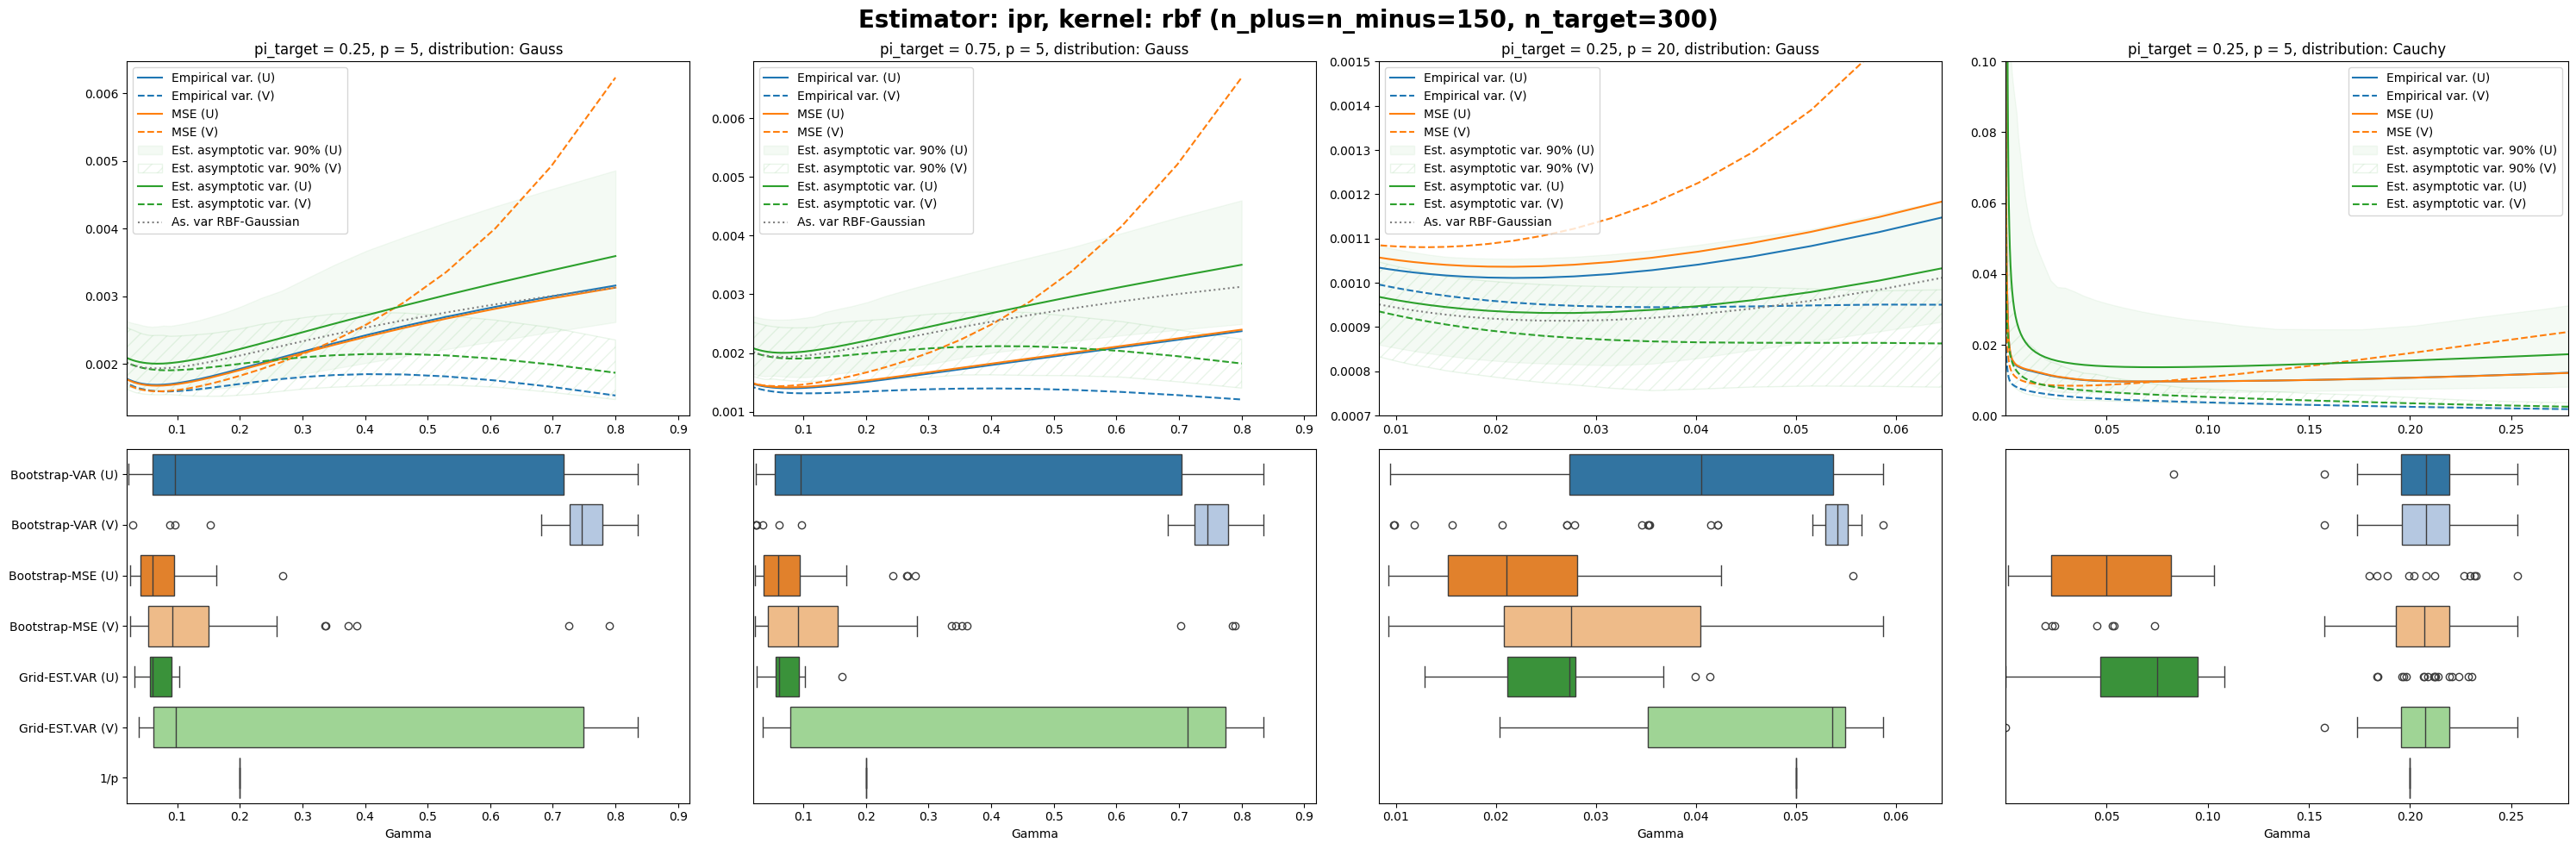

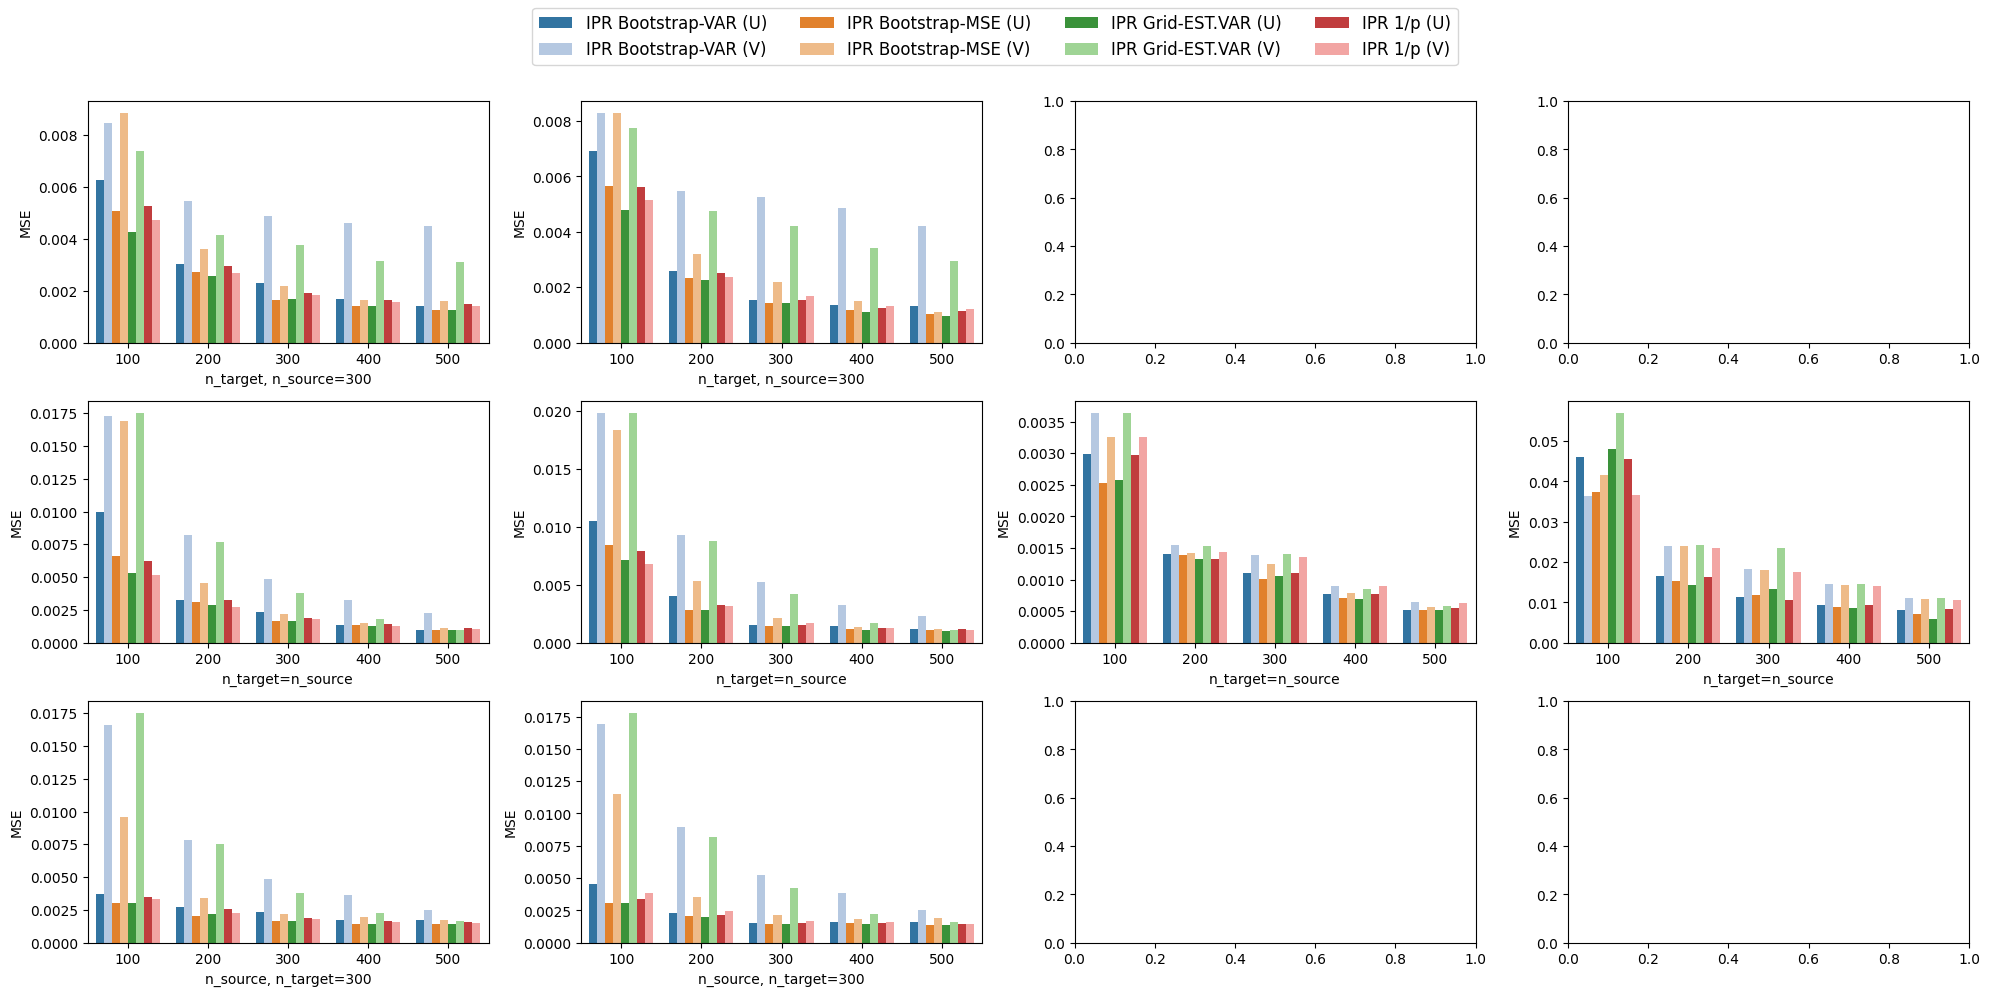

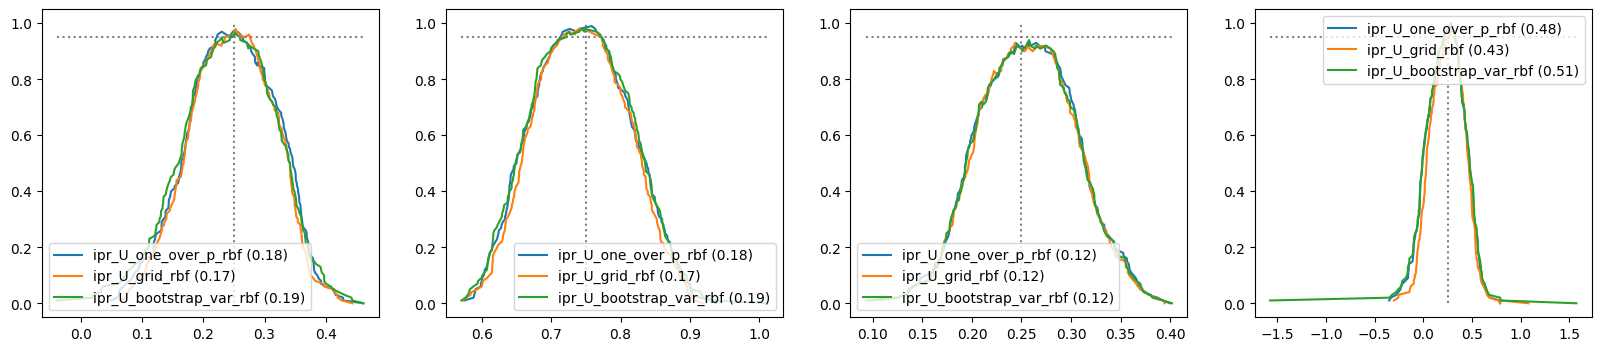

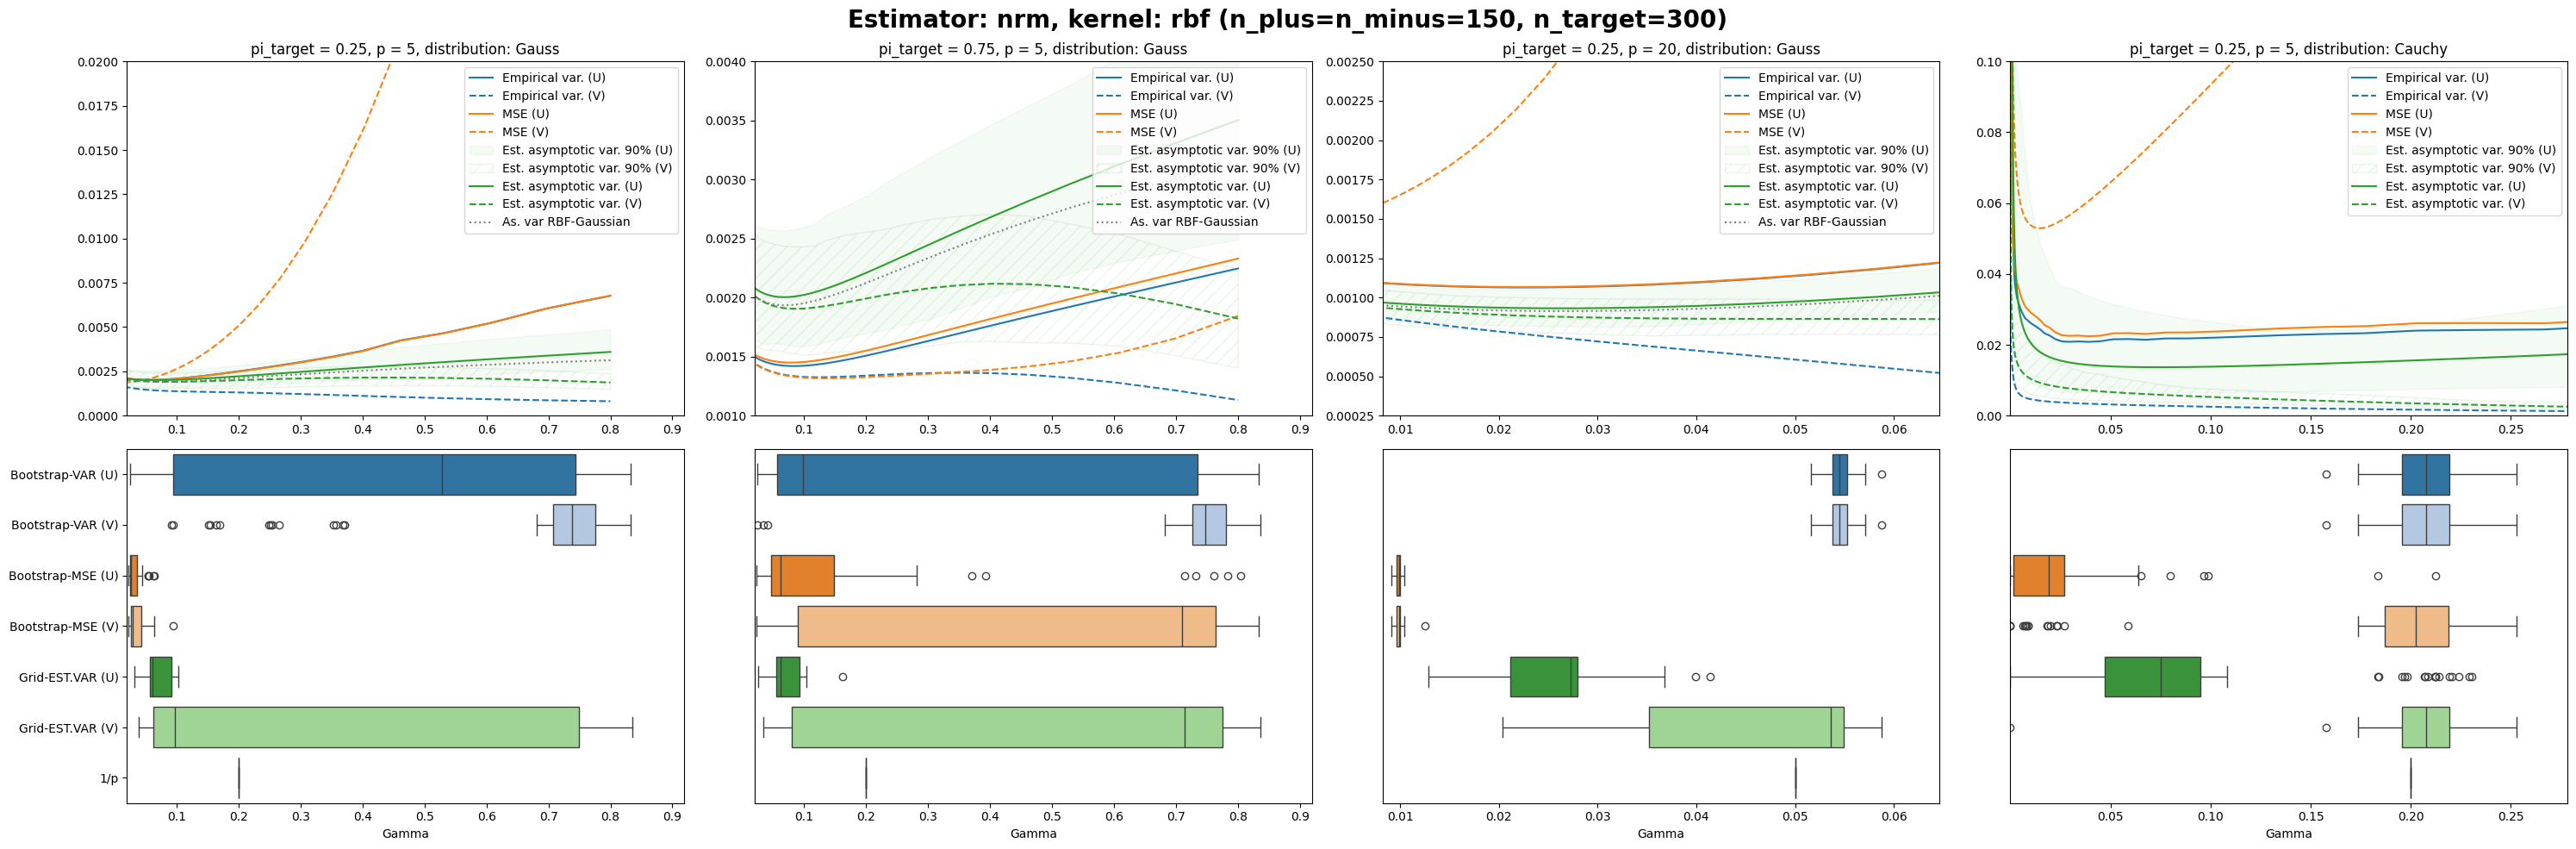

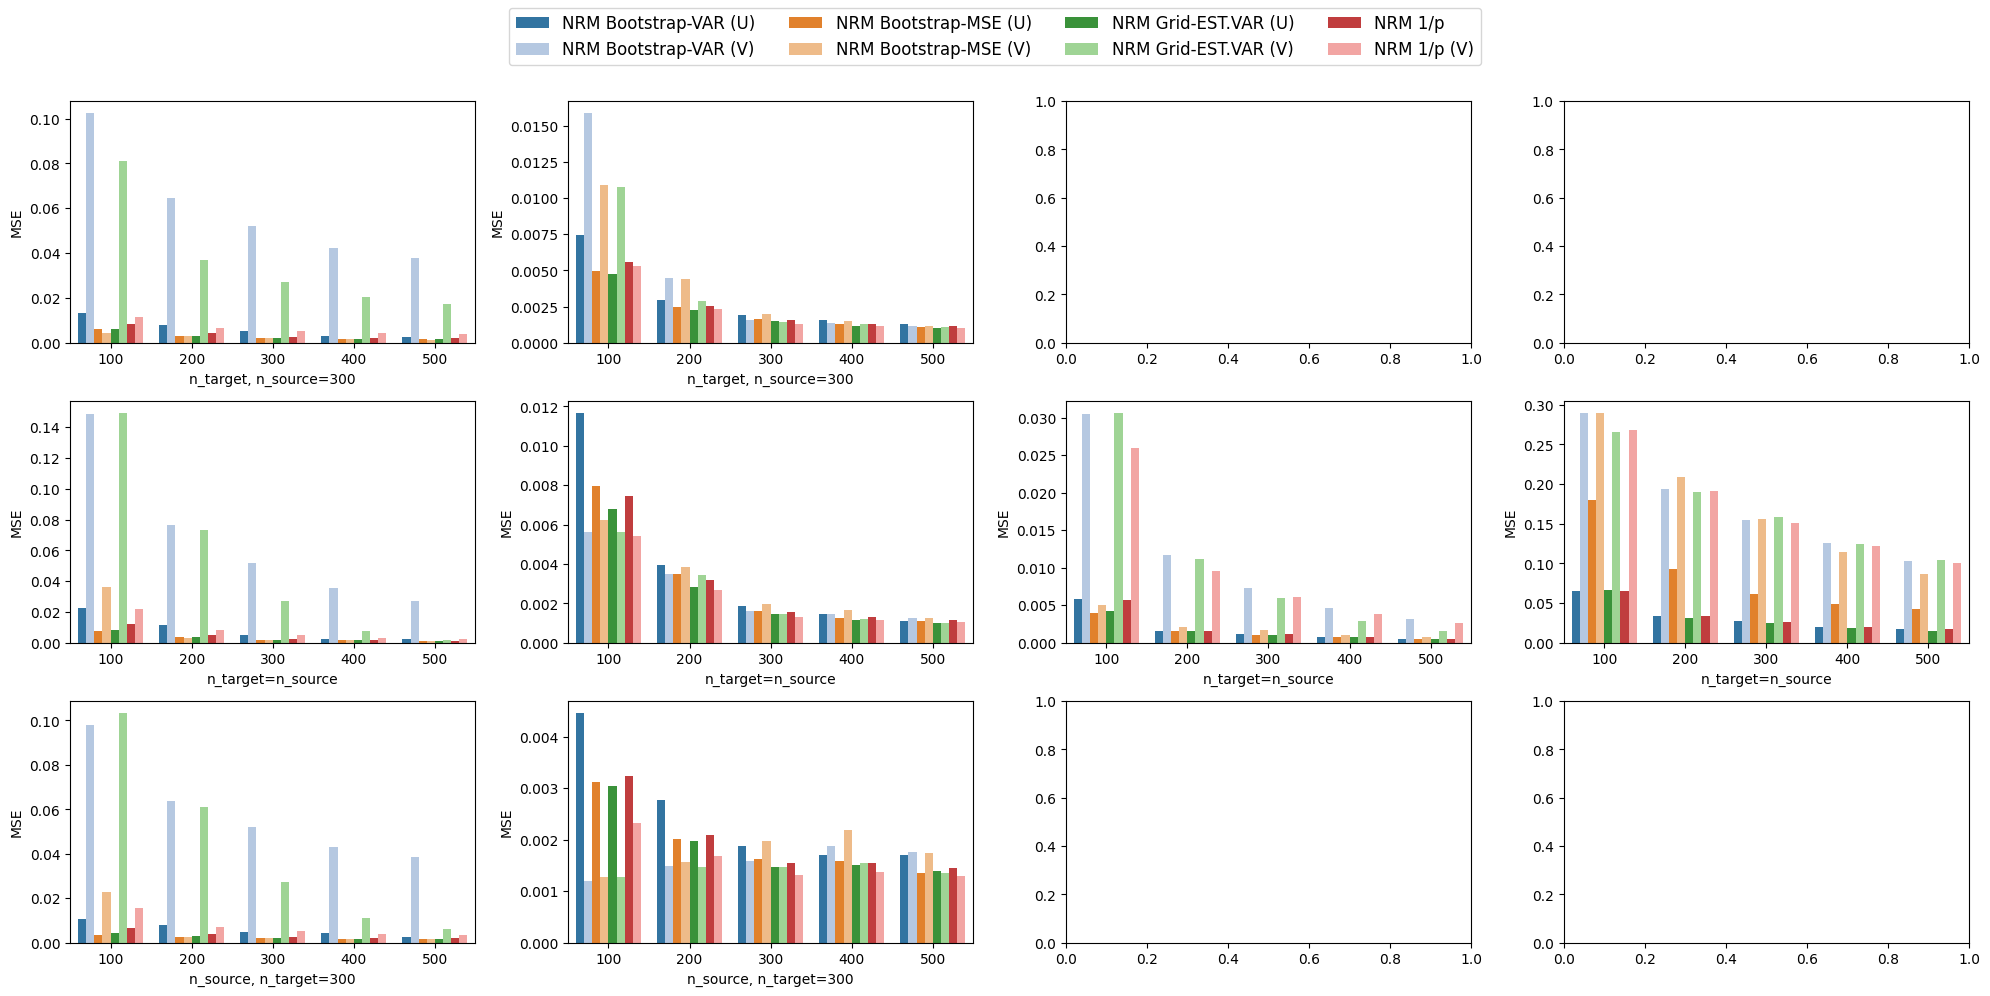

In [181]:
plot_scores_and_boxplots(pd.concat(df_estimators_sim_list), pd.concat(df_gamma_selection_list),
                         estimator='ipr', pi_target=0.25, kernel='rbf',
                         y_lim_list=[[None, None],[None, None],[0.0007, 0.0015], [0, 0.1]])
plot_barplots_mse(df, pi_target=0.25)
fig, axes = plt.subplots(ncols=4, figsize=(20, 4))
plot_ci_curve(axes[0], df_all, ['ipr', 'ipr', 'ipr'], ['rbf', 'rbf', 'rbf'], ['one_over_p', 'grid', 'bootstrap_var'], ['U', 'U', 'U'],
              0.25, 'sim_par_4', 150, 300, 5, 'Gaussian')
plot_ci_curve(axes[1], df_all, ['ipr', 'ipr', 'ipr'], ['rbf', 'rbf', 'rbf'], ['one_over_p', 'grid', 'bootstrap_var'], ['U', 'U', 'U'],
              0.75, 'sim_par_4', 150, 300, 5, 'Gaussian')
plot_ci_curve(axes[2], df_all, ['ipr', 'ipr', 'ipr'], ['rbf', 'rbf', 'rbf'], ['one_over_p', 'grid', 'bootstrap_var'], ['U', 'U', 'U'],
              0.25, 'sim_par_4', 150, 300, 20, 'Gaussian')
plot_ci_curve(axes[3], df_all, ['ipr', 'ipr', 'ipr'], ['rbf', 'rbf', 'rbf'], ['one_over_p', 'grid', 'bootstrap_var'], ['U', 'U', 'U'],
              0.25, 'sim_par_4', 150, 300, 5, 'Cauchy')
plot_scores_and_boxplots(pd.concat(df_estimators_sim_list), pd.concat(df_gamma_selection_list),
                         estimator='nrm', pi_target=0.25, kernel='rbf',
                         y_lim_list=[[0, 0.02],[0.001, 0.004],[0.00025, 0.0025], [0, 0.1]])
plot_barplots_mse(df, pi_target=0.25, estimator=['nrm'])

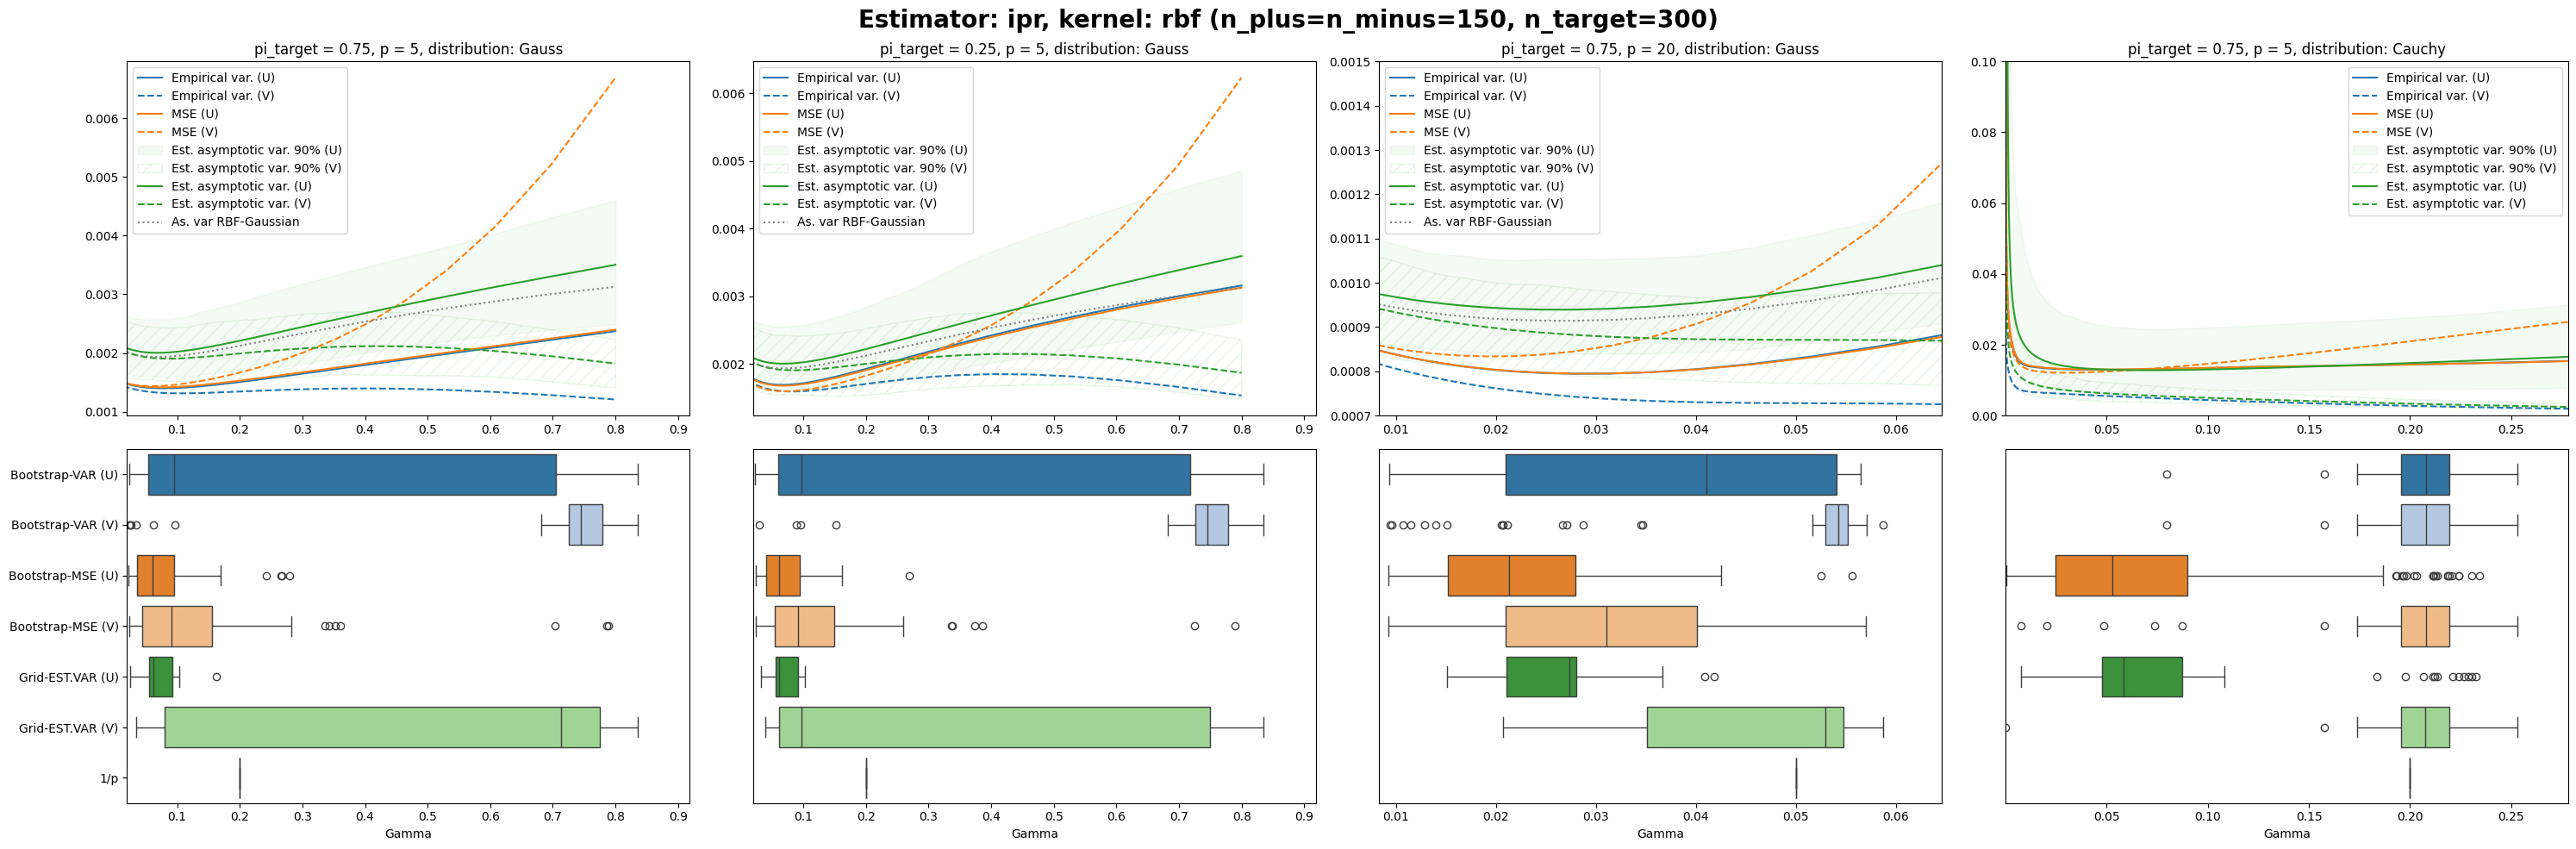

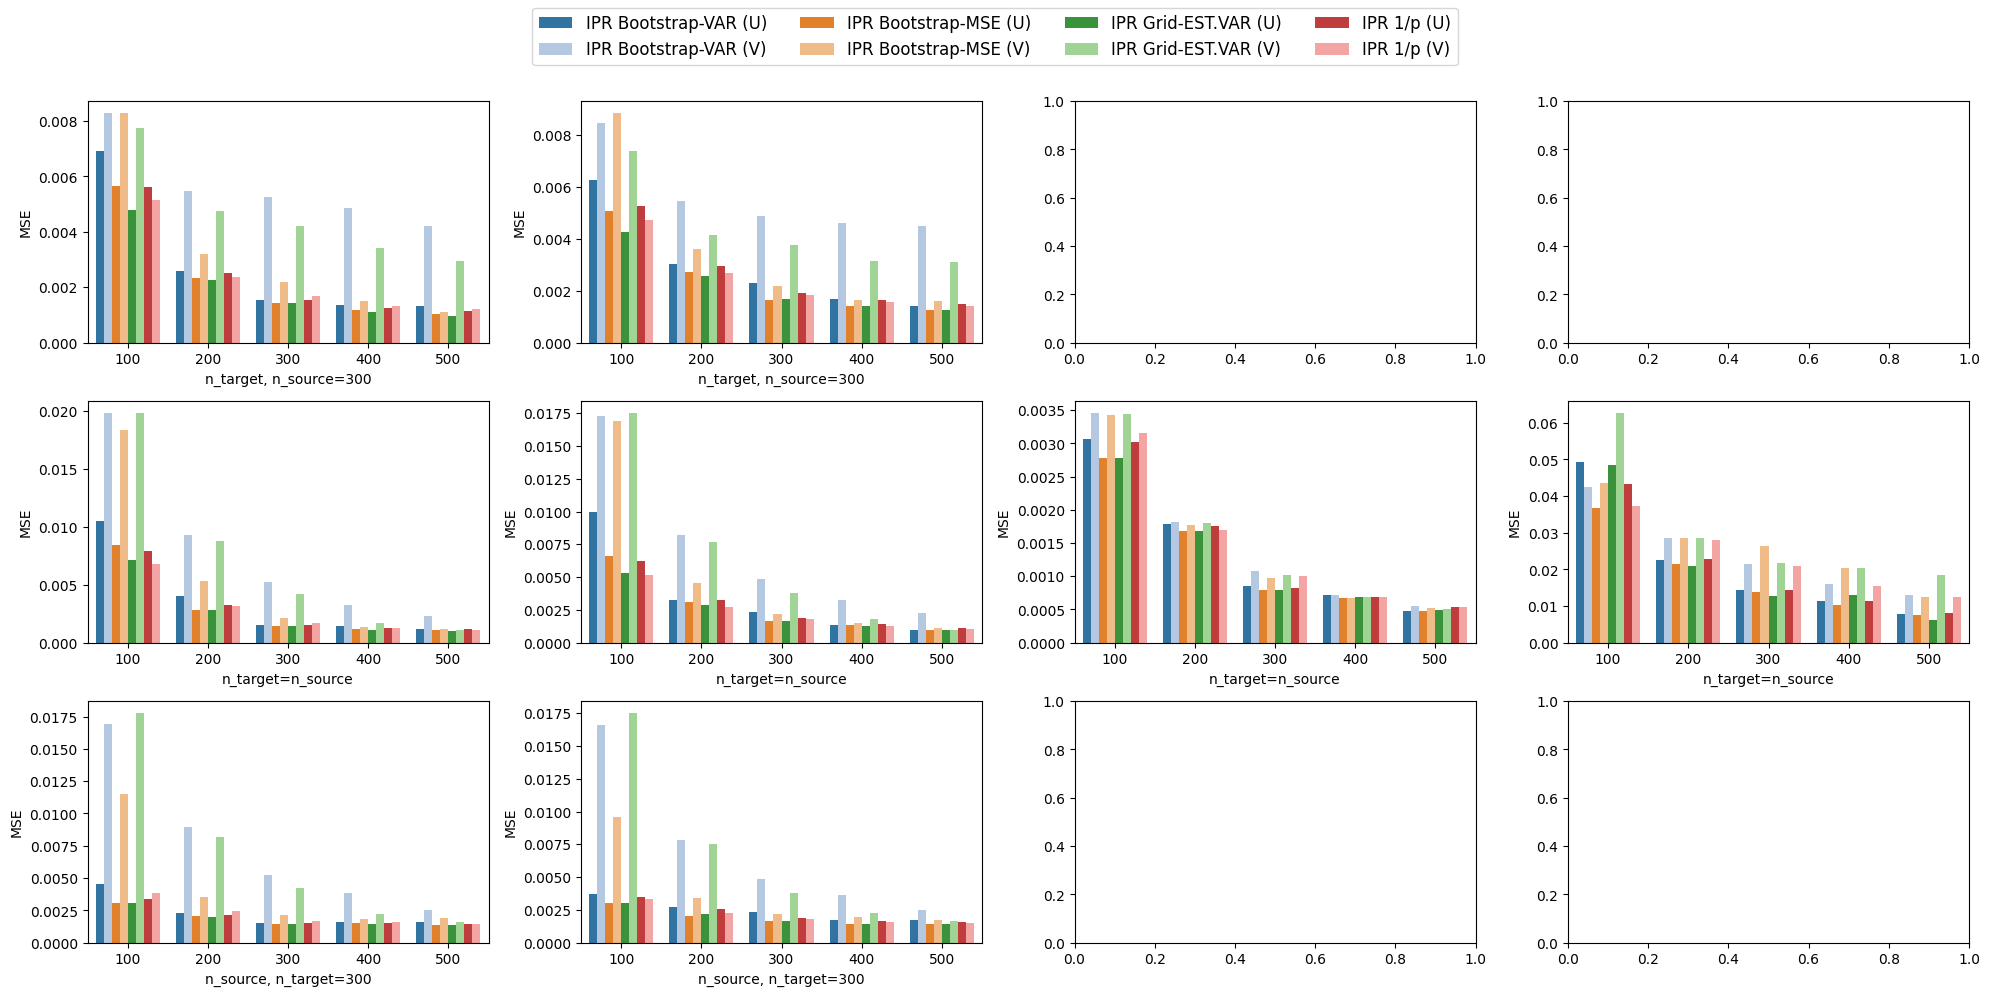

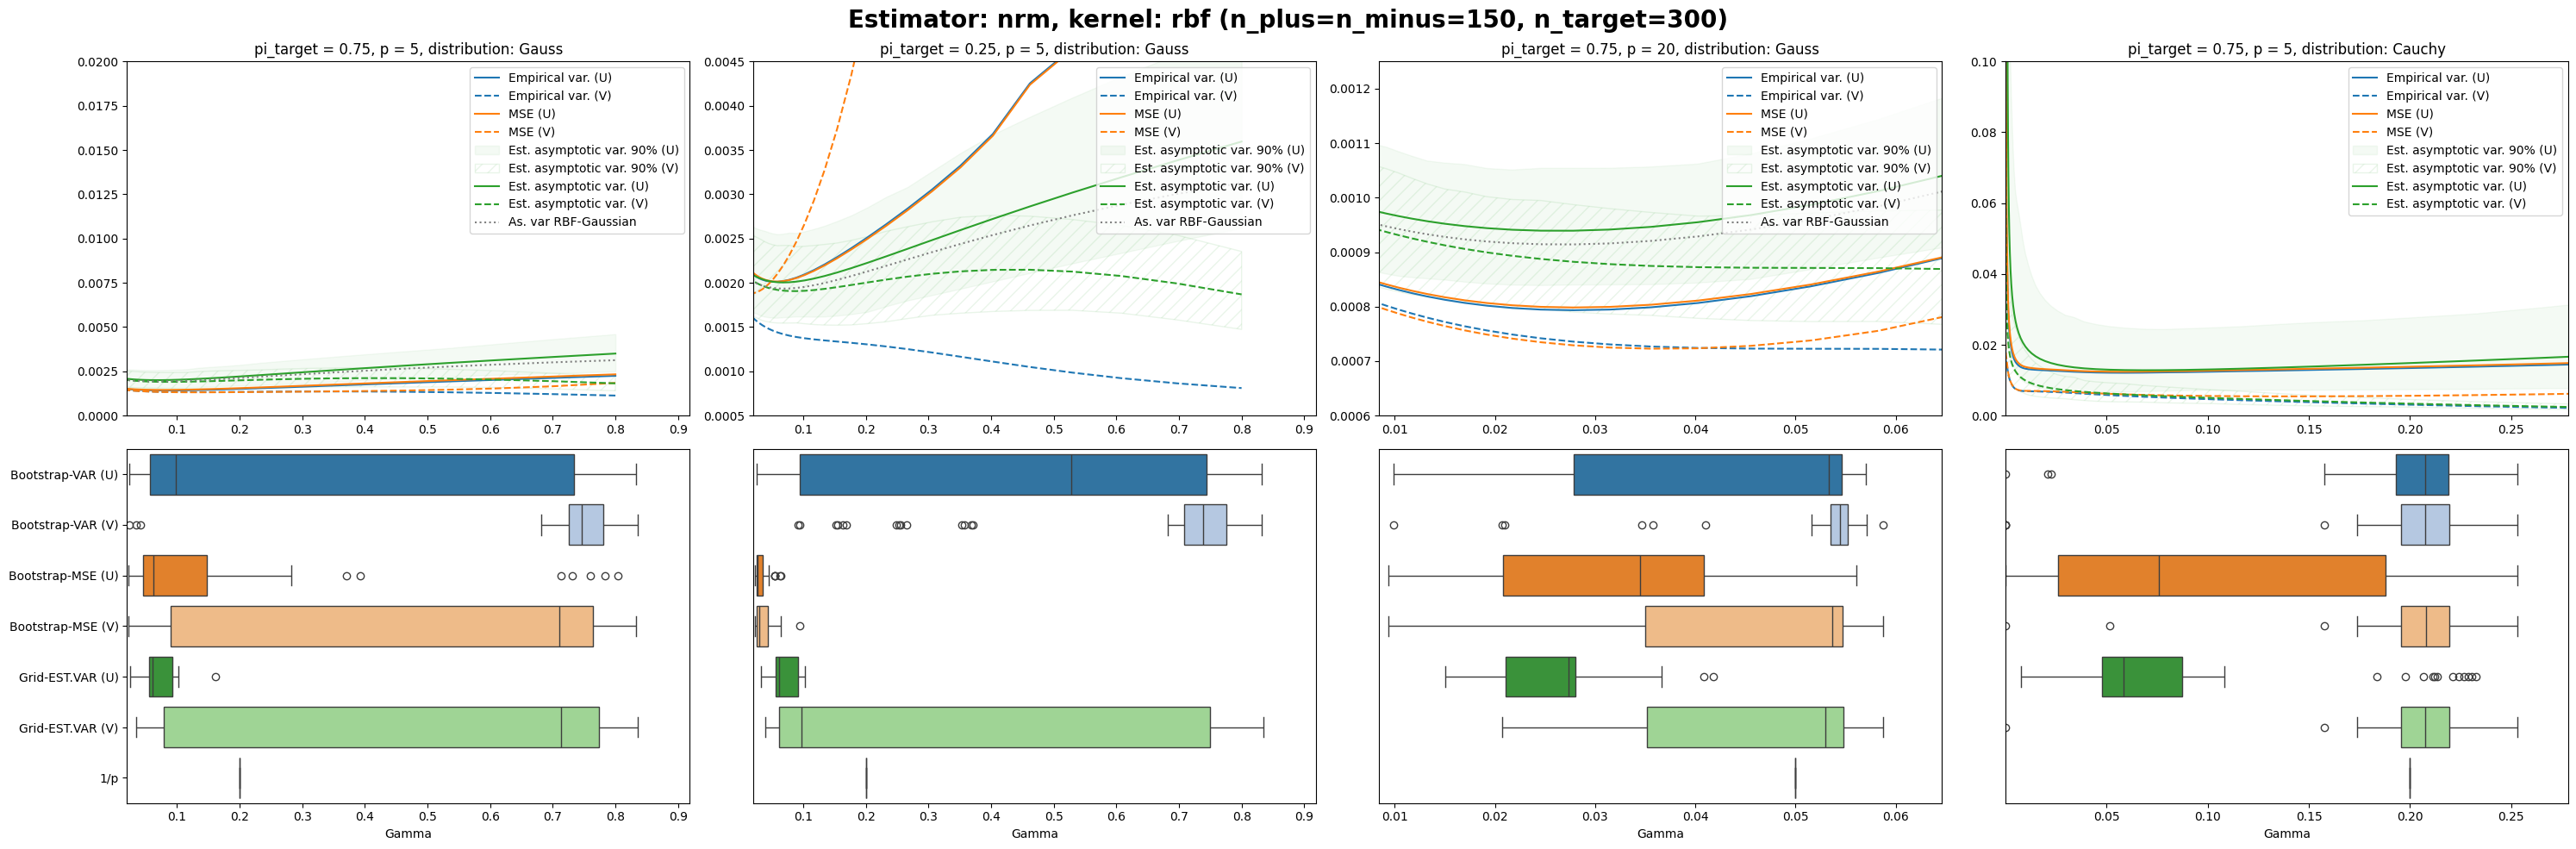

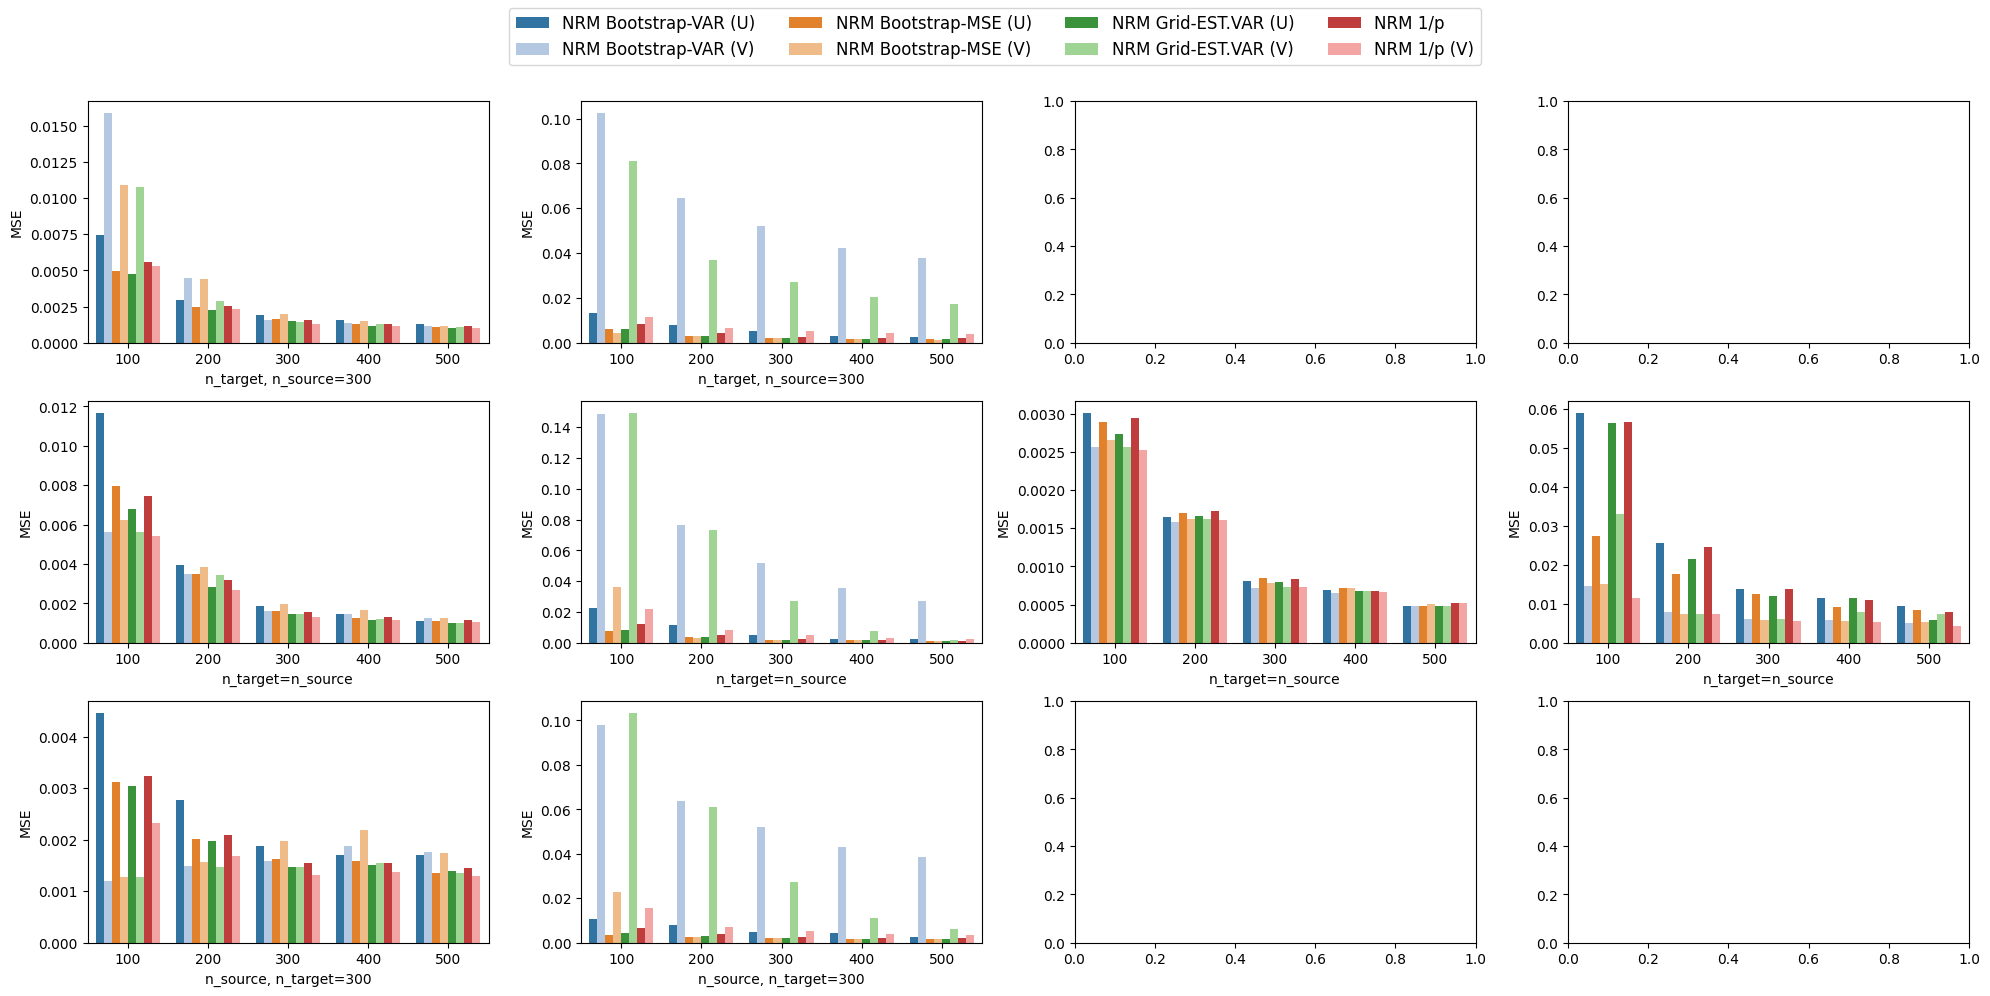

In [182]:
plot_scores_and_boxplots(pd.concat(df_estimators_sim_list), pd.concat(df_gamma_selection_list),
                         estimator='ipr', pi_target=0.75, kernel='rbf',
                         y_lim_list=[[None, None],[None, None],[0.0007, 0.0015], [0, 0.1]])
plot_barplots_mse(df, pi_target=0.75)
plot_scores_and_boxplots(pd.concat(df_estimators_sim_list), pd.concat(df_gamma_selection_list),
                         estimator='nrm', pi_target=0.75, kernel='rbf',
                         y_lim_list=[[0, 0.02],[0.0005, 0.0045],[0.0006, 0.00125], [0, 0.1]])
plot_barplots_mse(df, pi_target=0.75, estimator=['nrm'])

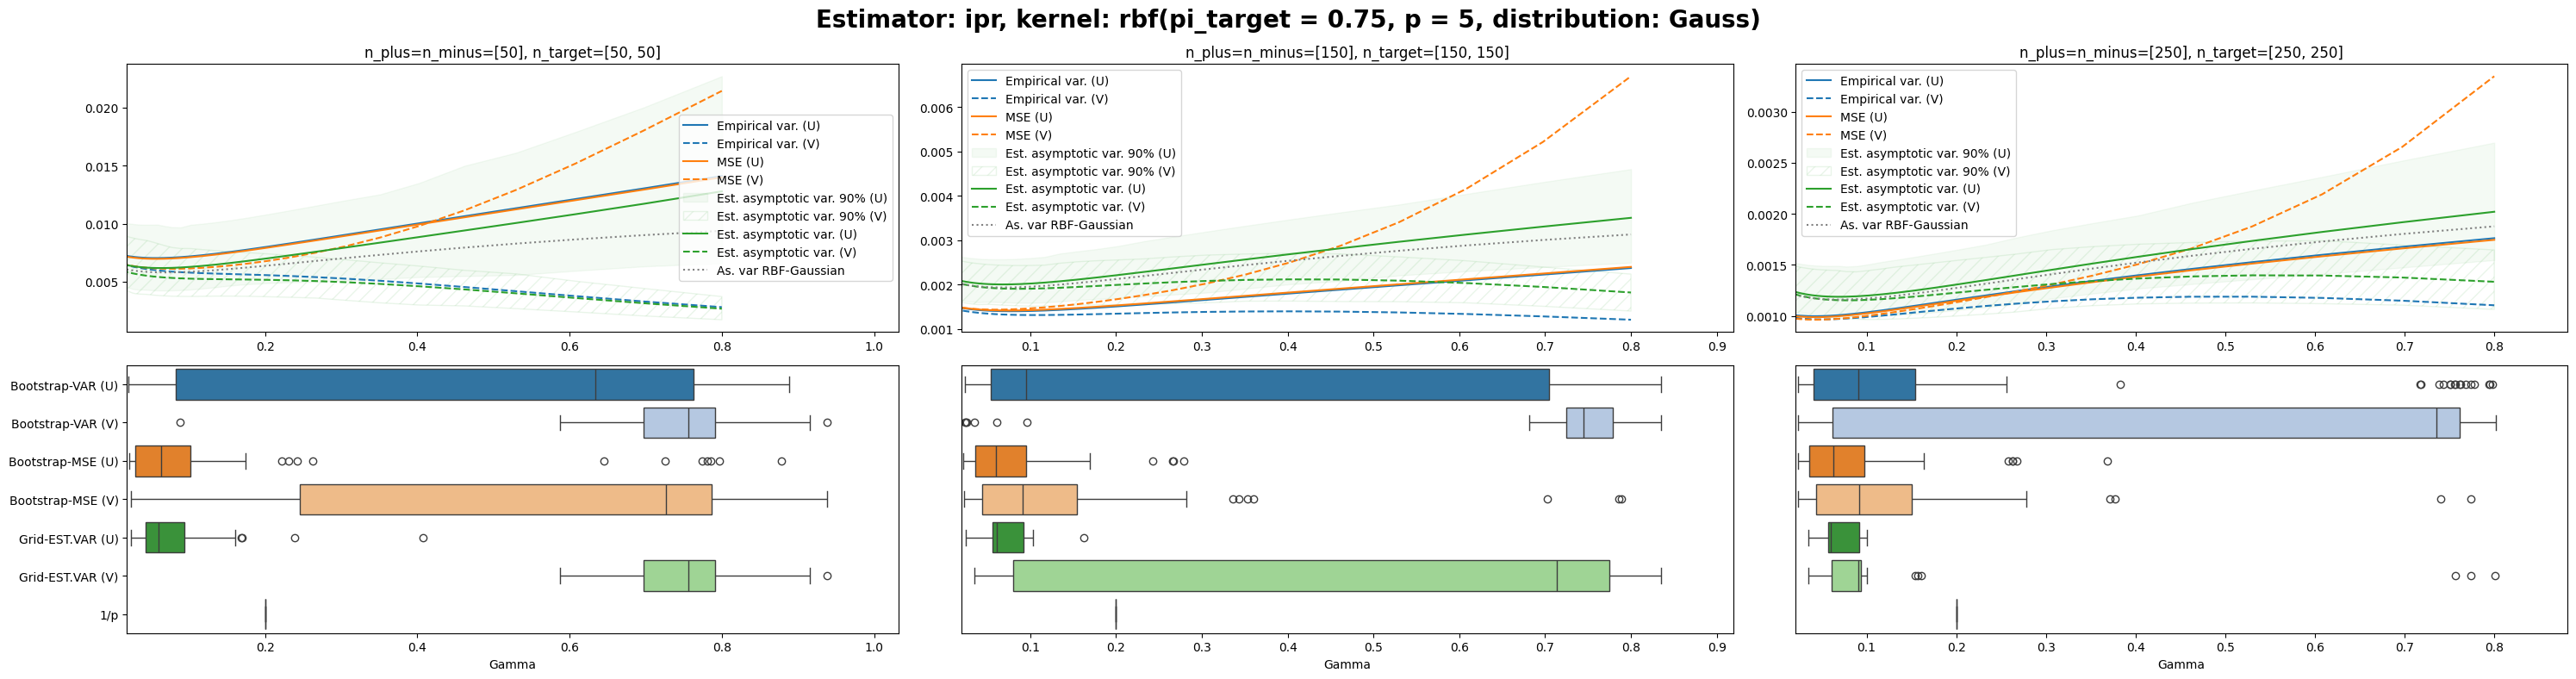

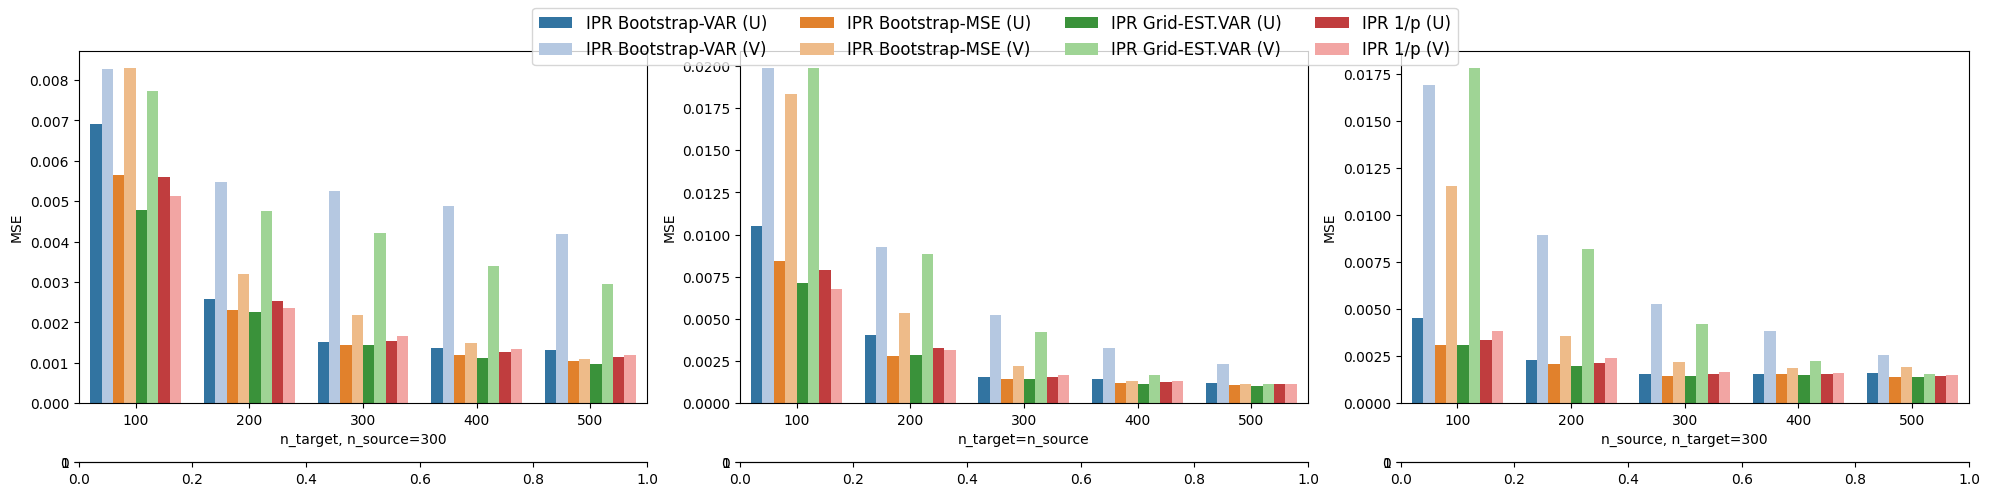

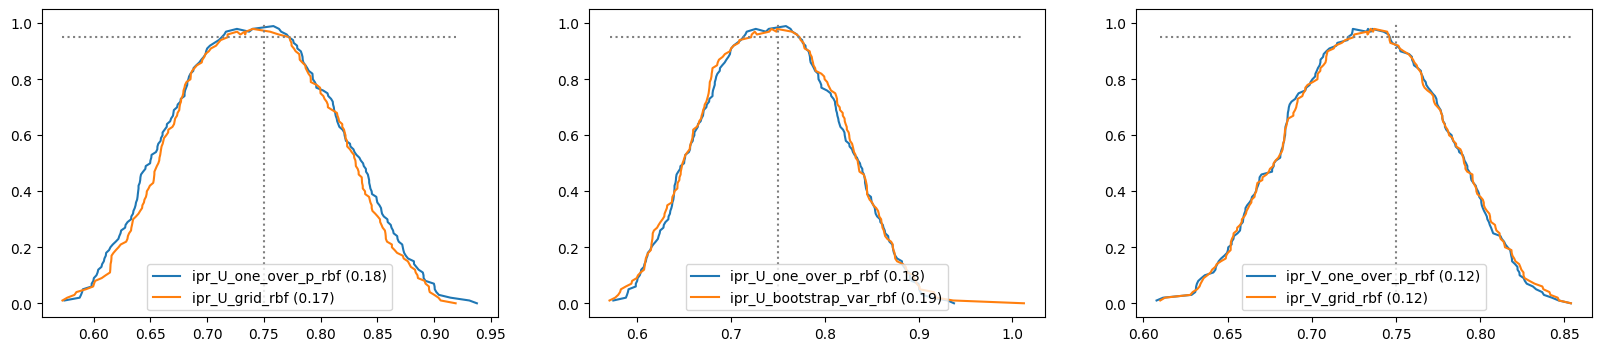

In [194]:
plot_scores_and_boxplots2(pd.concat(df_estimators_sim_list), pd.concat(df_gamma_selection_list),
                         estimator='ipr', pi_target=0.75, kernel='rbf')
plot_barplots_mse2(df, pi_target=0.75)
fig, axes = plt.subplots(ncols=3, figsize=(20, 4))
plot_ci_curve(axes[0], df_all, ['ipr', 'ipr'], ['rbf', 'rbf', 'rbf'], ['one_over_p', 'grid'], ['U', 'U'],
              0.75, 'sim_par_4', 150, 300, 5, 'Gaussian')
plot_ci_curve(axes[1], df_all, ['ipr', 'ipr'], ['rbf', 'rbf', 'rbf'], ['one_over_p', 'bootstrap_var', 'bootstrap_mse'], ['U', 'U', 'U'],
              0.75, 'sim_par_4', 150, 300, 5, 'Gaussian')
plot_ci_curve(axes[2], df_all, ['ipr', 'ipr'], ['rbf', 'rbf', 'rbf'], ['one_over_p', 'grid'], ['V', 'V', 'U'],
              0.75, 'sim_par_4', 150, 300, 20, 'Gaussian')

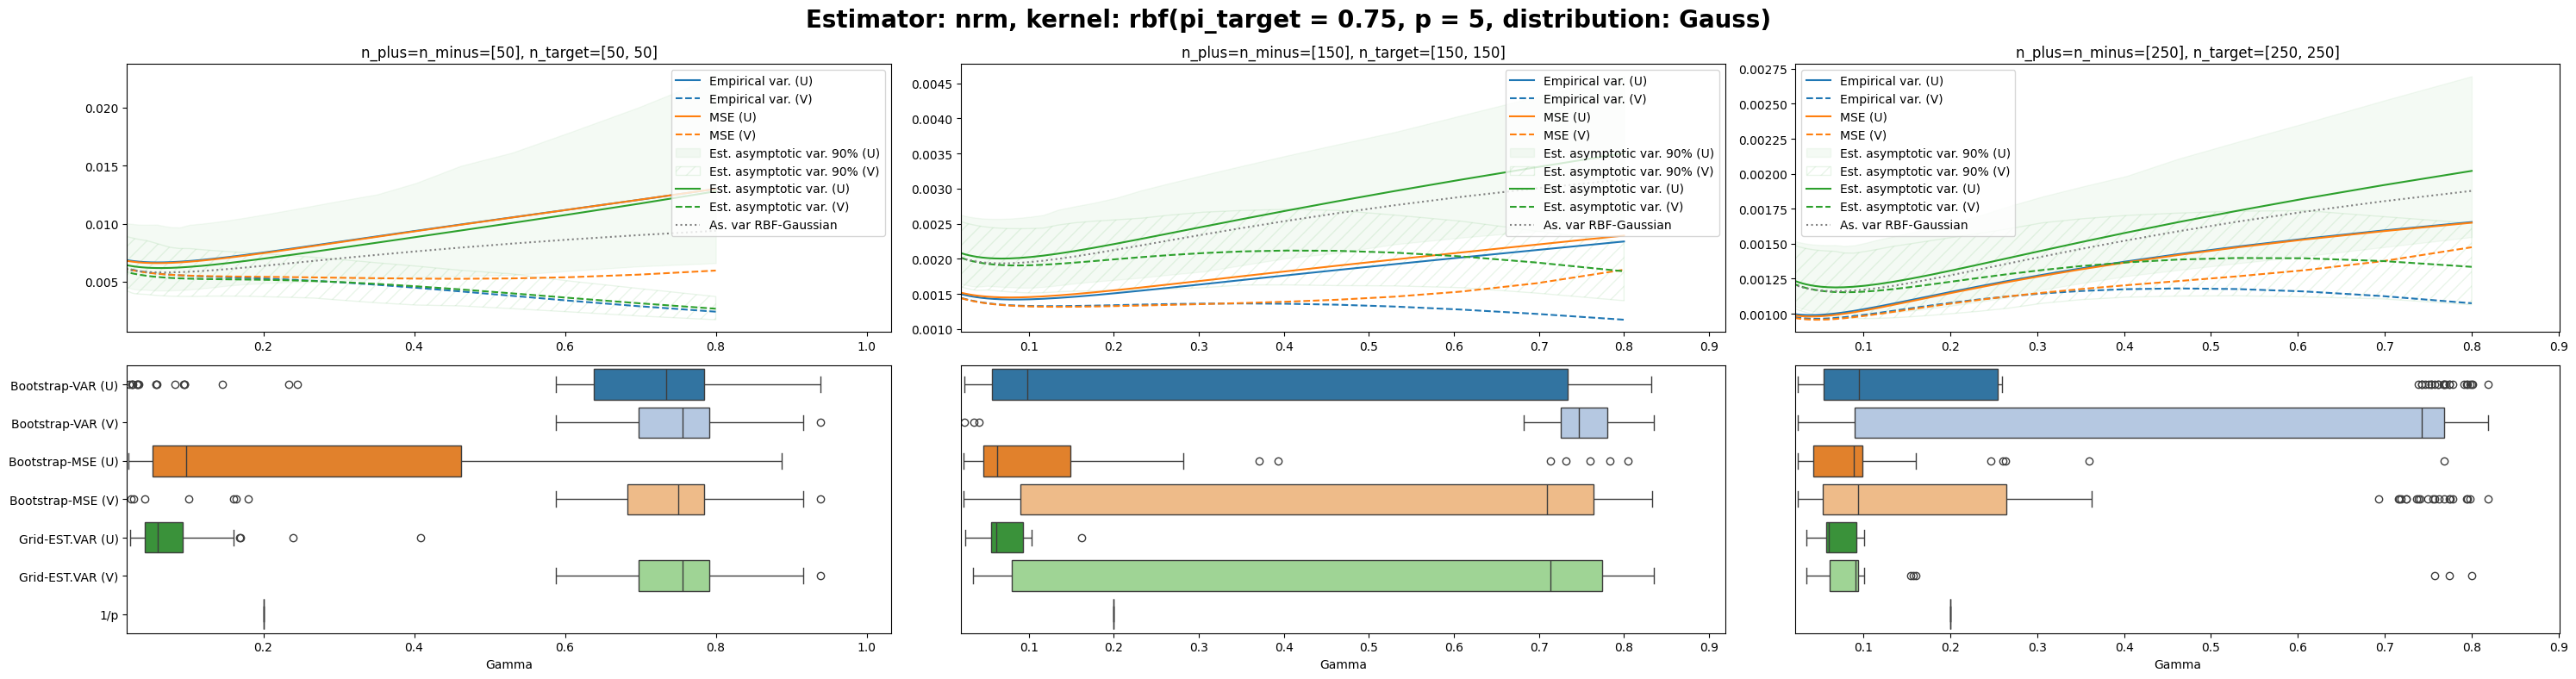

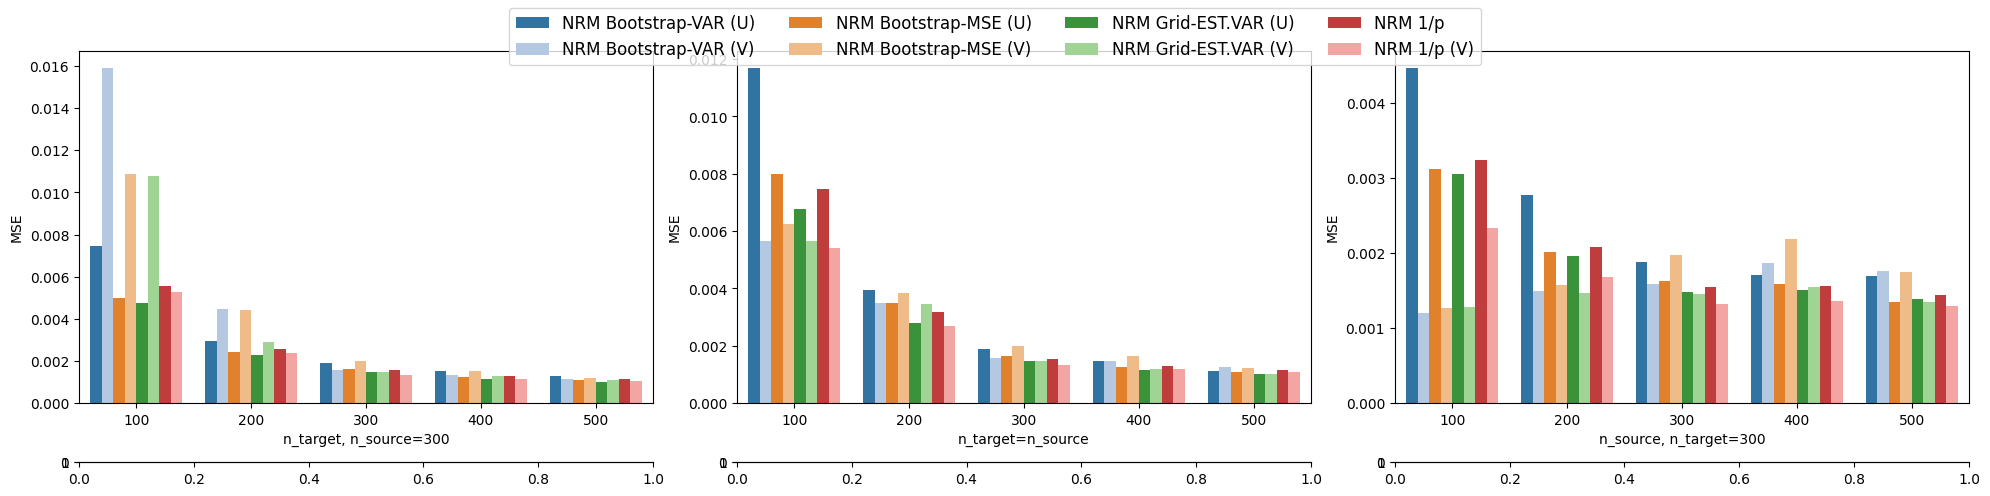

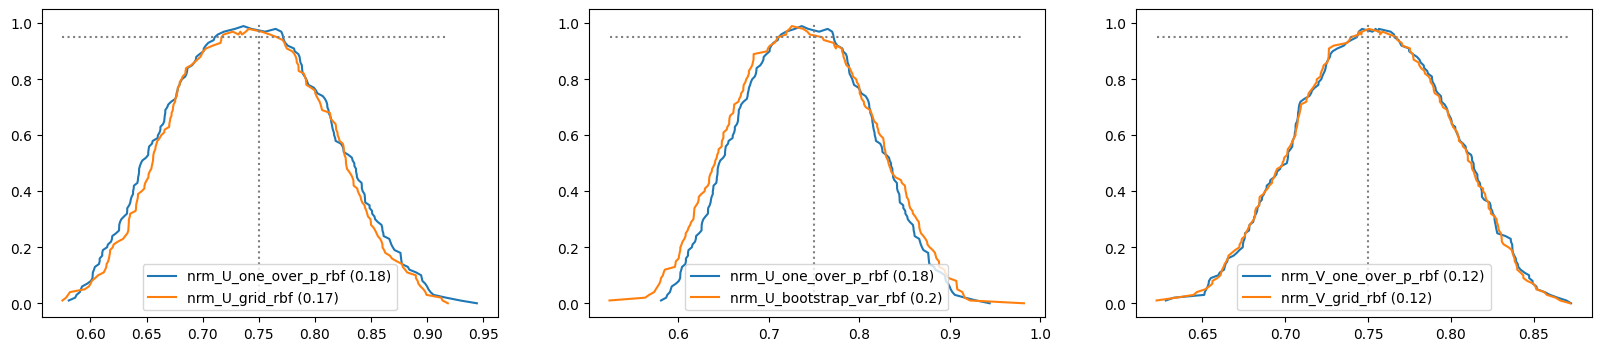

In [199]:
plot_scores_and_boxplots2(pd.concat(df_estimators_sim_list), pd.concat(df_gamma_selection_list),
                         estimator='nrm', pi_target=0.75, kernel='rbf')
plot_barplots_mse2(df, pi_target=0.75, estimator=['nrm'])
fig, axes = plt.subplots(ncols=3, figsize=(20, 4))
plot_ci_curve(axes[0], df_all, ['nrm', 'nrm'], ['rbf', 'rbf', 'rbf'], ['one_over_p', 'grid'], ['U', 'U'],
              0.75, 'sim_par_4', 150, 300, 5, 'Gaussian')
plot_ci_curve(axes[1], df_all, ['nrm', 'nrm'], ['rbf', 'rbf', 'rbf'], ['one_over_p', 'bootstrap_var', 'bootstrap_mse'], ['U', 'U', 'U'],
              0.75, 'sim_par_4', 150, 300, 5, 'Gaussian')
plot_ci_curve(axes[2], df_all, ['nrm', 'nrm'], ['rbf', 'rbf', 'rbf'], ['one_over_p', 'grid'], ['V', 'V', 'U'],
              0.75, 'sim_par_4', 150, 300, 20, 'Gaussian')

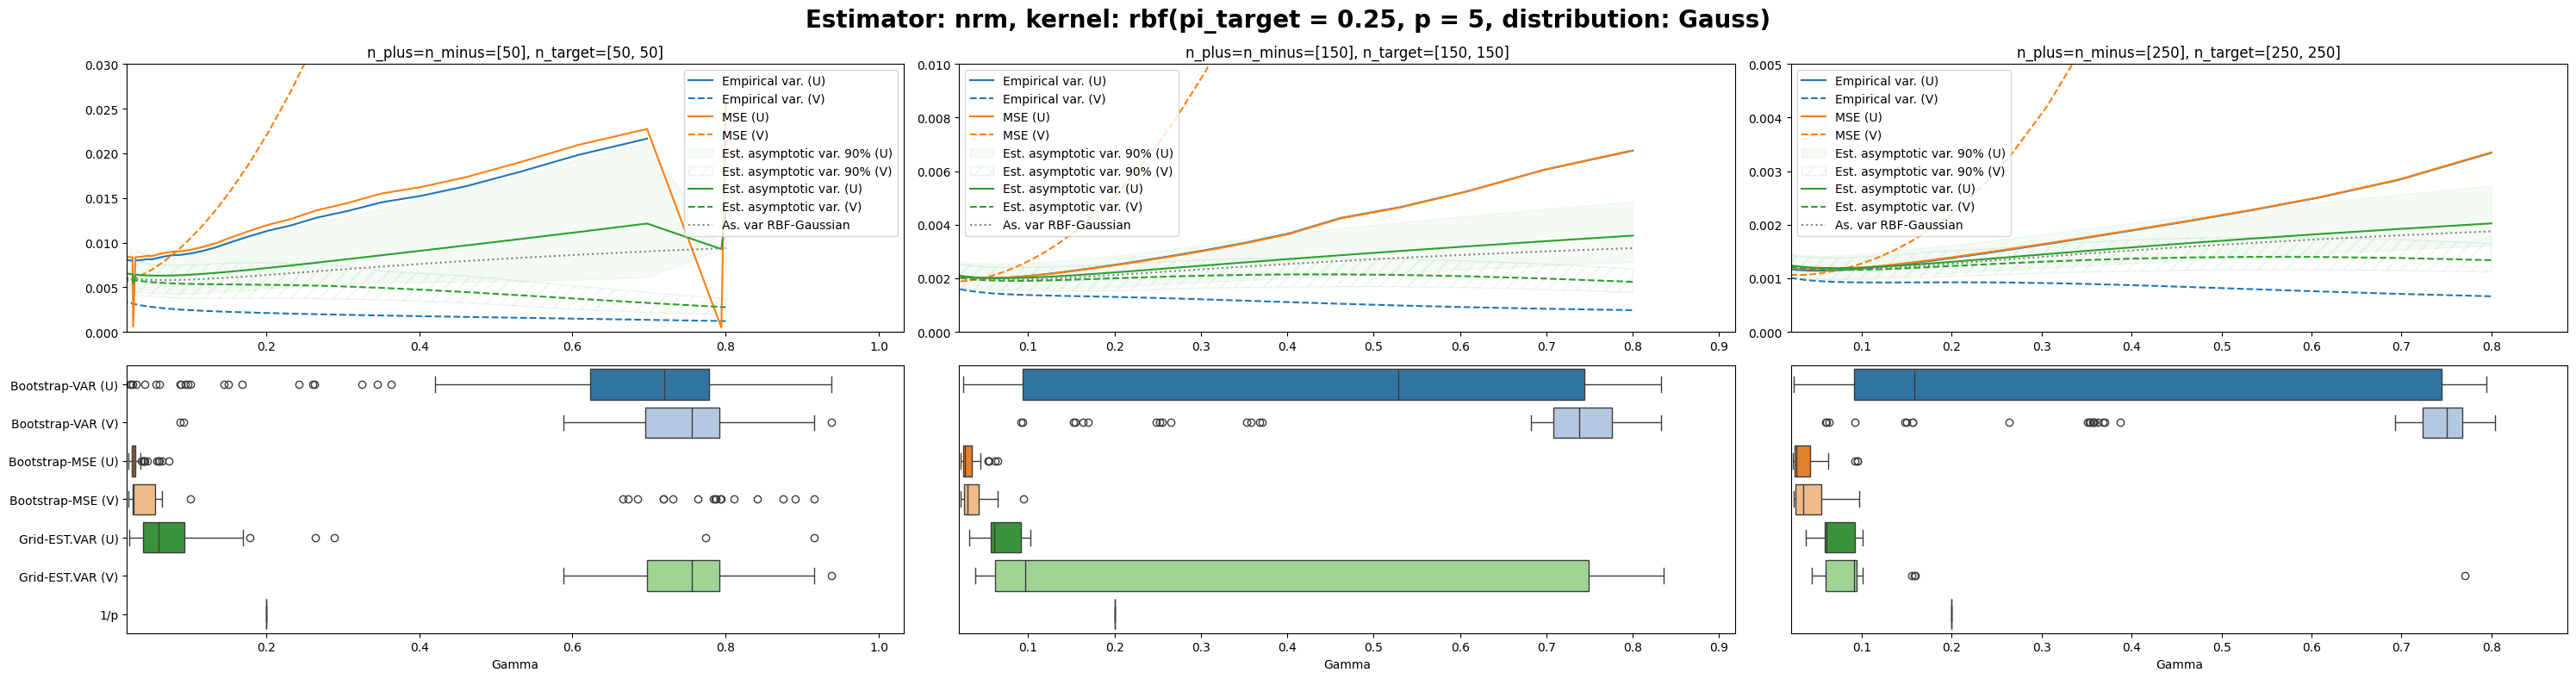

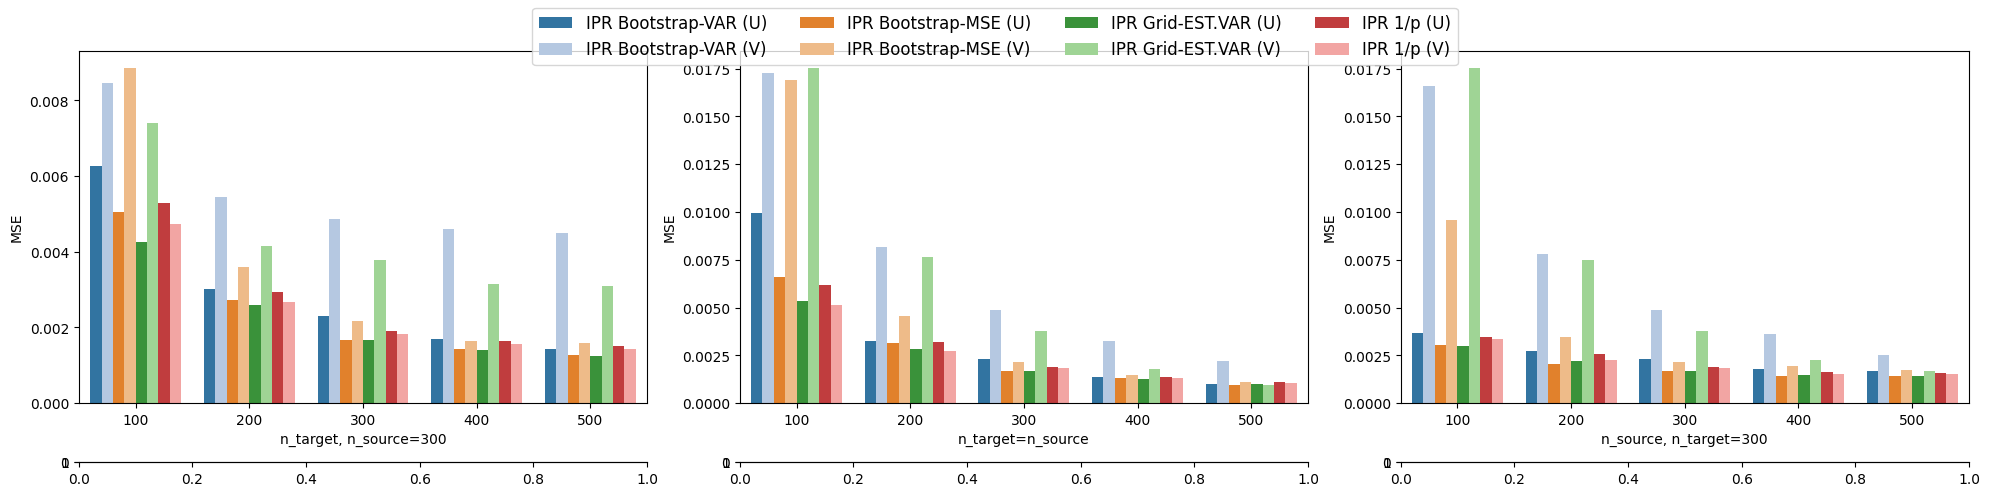

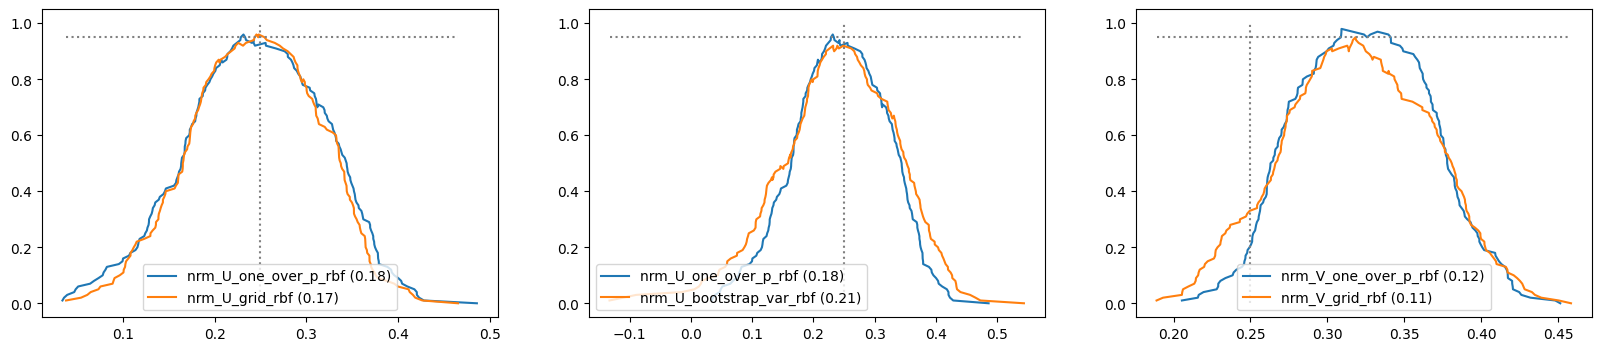

In [202]:
plot_scores_and_boxplots2(pd.concat(df_estimators_sim_list), pd.concat(df_gamma_selection_list),
                         estimator='nrm', pi_target=0.25, kernel='rbf',
                         y_lim_list=[[0, 0.03],[0.00, 0.01],[0.00, 0.005], [0, 0.1]])
plot_barplots_mse2(df, pi_target=0.25)
fig, axes = plt.subplots(ncols=3, figsize=(20, 4))
plot_ci_curve(axes[0], df_all, ['nrm', 'nrm'], ['rbf', 'rbf', 'rbf'], ['one_over_p', 'grid'], ['U', 'U'],
              0.25, 'sim_par_4', 150, 300, 5, 'Gaussian')
plot_ci_curve(axes[1], df_all, ['nrm', 'nrm'], ['rbf', 'rbf', 'rbf'], ['one_over_p', 'bootstrap_var', 'bootstrap_mse'], ['U', 'U', 'U'],
              0.25, 'sim_par_4', 150, 300, 5, 'Gaussian')
plot_ci_curve(axes[2], df_all, ['nrm', 'nrm'], ['rbf', 'rbf', 'rbf'], ['one_over_p', 'grid'], ['V', 'V', 'U'],
              0.25, 'sim_par_4', 150, 300, 20, 'Gaussian')